# PolyP AspectRatio Analysis

#### Description

This code uses the Python (v3.10.11) and packages Scikit-image, NumPy, Pandas, and MatplotLib to identify single fusion events of two condensates in pre-processed image files. Each fusion event is fit to the equation AR = (AR0 - 1)*e^(-t/tau) +1,  where AR is the aspect ratio of the fusing droplets, AR0 is the aspect ratio at time 0, t is time and tau is the time constant of decay. Aspect ratio, approximate length scale of the fusion event, and tau are recorded and output. This process is repeated across multiple events and the resulting data is compiled into a csv file. 

#### Contributors
Written by: Jenna Tom\
Deniz Lab, www.scripps.edu/deniz

Corresponding Author: Ashok Deniz\
Institution: The Scripps Research Institute\
ORCID: 0000-0003-2819-4049\
GitHub: https://github.com/Deniz-Lab \
Email: deniz@scripps.edu 

#### Dependencies
Code uses packages from NumPy, Matplotlib, pandas, skimage (Scikit-Image), and scipy. These must be installed before running this code.

It also requires the files aspectratio.py and parsekey_wrangling.py (Developed by Emily Bentley) to be saved in the same directory (folder) as the notebook. These files are available in the github repository linked above.

Similarly, this notebook needs to be in the same directory (folder) as "PolyPFusion_tifFiles", the folder storing our tif images from the publication below. These can be accessed and downloaded from GitHub (https://github.com/Deniz-Lab/condensate-fusion-aspect-ratio).

#### Published & Used in
Ravi Chawla*, Jenna K. A. Tom*, Tumara Boyd, Nicholas Tu, Tanxi Bai, Danielle A. Grotjahn, Donghyun Park, Ashok A. Deniz, Lisa R. Racki. "Reentrant DNA shells tune polyphosphate condensate size." 

For use, please cite the above publication.

## Imports
The following block imports packages and modules as necessary.  

Two custom files are required: aspectratio.py & parsekey_wrangling.py. These need to be in the same working directory as the notebook.

###### To run a code cell, press Shift + Enter or the play icon.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import skimage.io
import math
import pandas as pd
import os
import glob

import aspectratio as ar
import parsekey_wrangling as pw

from scipy.spatial import distance
from scipy.optimize import curve_fit
from skimage import img_as_float
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects, binary_closing
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import disk

## Single File Demo

Using a single fusion example, we demonstrate an example of segmentation & fitting using the aspectratio.py file for a single fusion instance. 

Segmentation overlays & a graph showing the decay of aspect ratio over time and the corresponding fit can be shown by running the following code blocks. 

Figures for image overlays can be exported at the end by inputting "Y" or 'y' when prompted. To export the fit graph as a png, find the line that starts with "fusion_1.graph_fit" and change "save_graph = False" to "save_graph = True". For more details, see comments in code block 3. 

#### Importing tif file & establishing initial parameters

test_im is read in as an array. 

Properties (list of strings): desired properties recorded from each region of each frame formatted as a list. We record three: area, major axis length, and minor axis length. These are the minimal set for the droplet module to work. Additional parameters as measured by skimage.measure.regionprops can be selected. Order does not matter, but the string is case sensitive and must match the formatting of skimage.measure.regionprops parameters. 

analysis var (string): the version of image that is segmented/analyzed. In this case, the choices are 'clean' or 'binary'

fit function (string): name of fit function saved in aspectratio.py--only one added currently is two_param_fit. 

In [2]:
test_im = skimage.io.imread("PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_200-249.tif")

properties = ['area', 'axis_major_length', 'axis_minor_length']

analysis_var = 'clean'
fit_function = "two_param_fit"

#### DropletFusion Demo

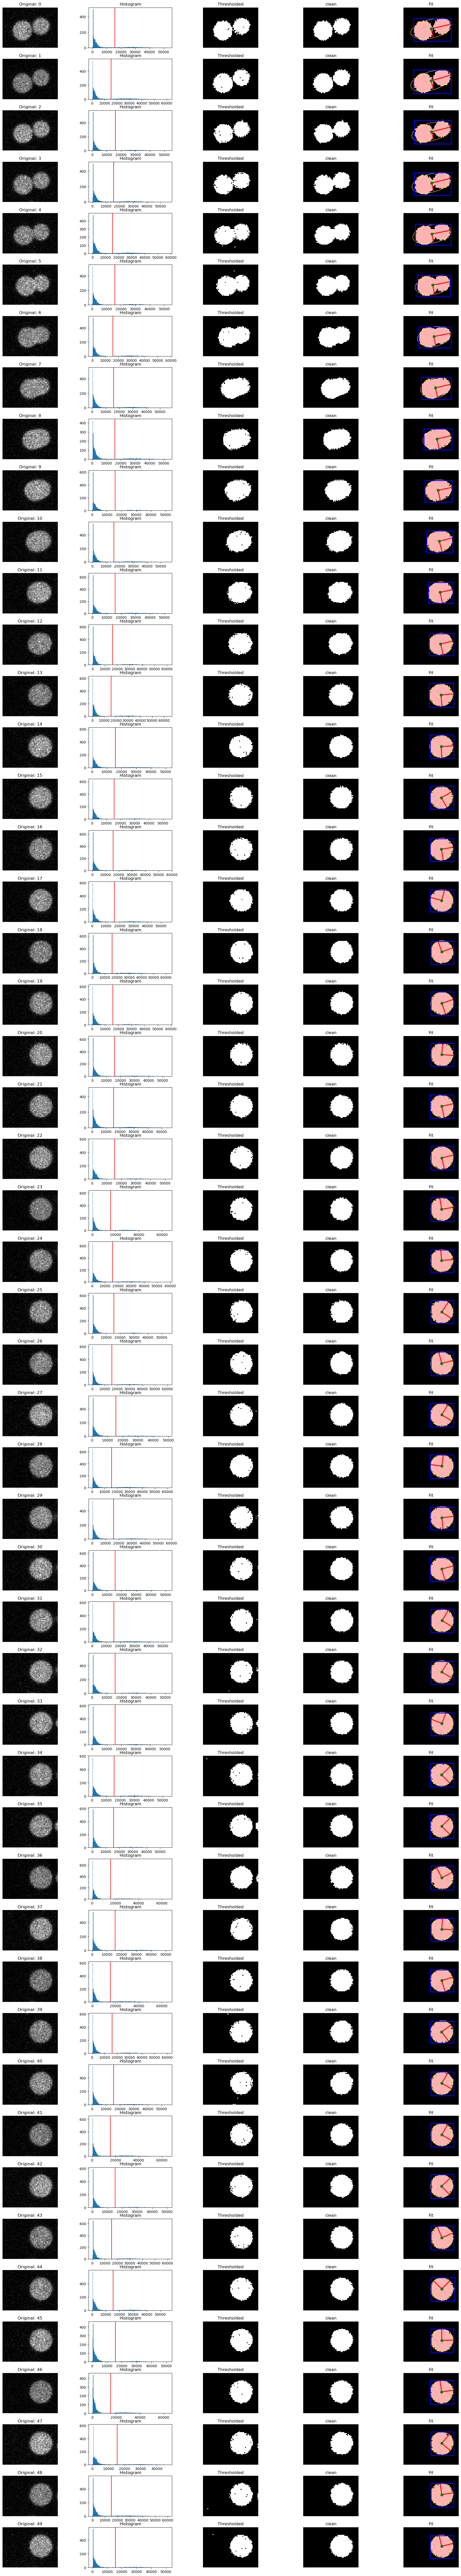

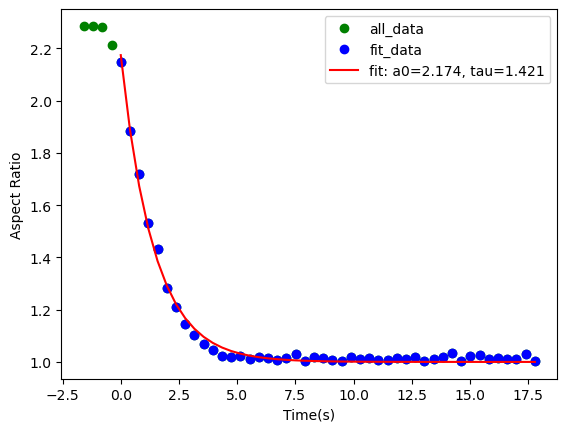

File does not match internal names. Manually approve by typing Y or N for file(s) to save
segmentation-clean? (Y/N)n
clean? (Y/N)n


In [3]:
fusion_1 = ar.DropletFusion(test_im,properties)
if fusion_1.valid_properties:
    # Creates a binary image with otsu thresholding
    fusion_1.clean_image()

    # Visualization of segmentation overlay. To hide but still generate figure for export, change surpress_show to True
    fusion_1.segmentation_overlay(analysis_var, surpress_show = False)

    # Calculates region properties & aspect ratio
    fusion_1.calc_properties(analysis_var)
    fusion_1.calc_aspect_ratio()

    # Assigns a fit with two parameters to the equation:
    # AR = (AR0 - 1)*e^(-t/tau) + 1, where AR0 is the initial aspect ratio at time 0 and tau is the time constant
    # To export the fit graph, change save_graph to True
    fusion_1.fit_relaxation(fit_function)
    fusion_1.graph_fit(func = fit_function, save_graph = False, file_name = "20240608_22_E_200-249_test",file_type = "png")

    # image_fig shows a panel of a particular type of image set (original, binary, clean) with an input of "im", "binary", "clean" respectively
    fusion_1.image_fig(analysis_var, surpress_show = True)

    # Exports image figures. If all wanted, use string "all." Else, program will prompt for individual inputs. 
    ## Can manually preset to a specific fig str ('thresholding', 'segmentation-[analysisVar]','[imageset]'),
    ## but requires image_fig, segmentation_overlay, or threshold_fig to be run first.
    fusion_1.export_figs(figs_to_export = '', file_name = "20240608_22_E_200-249_test", file_type = 'png')

## Batch Process Analysis

#### Generating list of files

In [4]:
file_list = glob.glob("PolyPFusion_tifFiles/*.tif")
# file_list

#### Creates parsekey object 

Takes file names and translates into properties using they specified key. 

In [5]:
fusion_240611 = pw.ParseKey(
    ("Date", str),
    ("ReadingNo",str),
    ("Sample",str),
    (["PolyP","[PolyP]"], [str,float]),
    ("Component 2", [str, float]),
    (["DNA","[DNA]"], [str, float]),
    ("DNALabel", [str, float]),
    ("PolyPLabel", [str, float]),
    (["Channel1","Ch1_Inten","Ch1_Gain","Ch1_Offset","Ch1_DigGain"], [str, int, int, int, int]),
    (["Channel2","Ch2_Inten","Ch2_Gain","Ch2_Offset","Ch2_DigGain"], [str, int, int, int, int]),
    (["DummyLabel","PixelDwell","ScanTime"],[str,float,float]),
    (["RunType","Delay"],[str,float]),
    ("Time",float),
    ("ReadingFrames",str),
    separator = ["_","-"],)

#### Batch processing of file_list

Adds parameters, dictionaries as iterates through file. 

Note: If you run into "RuntimeError: Parsekey does not have the same numbers of entries as the file path", it may be that your operating system naming is different. Try changing file.split('/') to file.split('\') or file.split('\\'). Alternatively, you can find the character to split on by changing "/" to the character(s) between "PolyP_tifFiles" and "20240608" in the printed output of the cell. 

PolyPFusion_tifFiles/20240608_91_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_30-85.tif


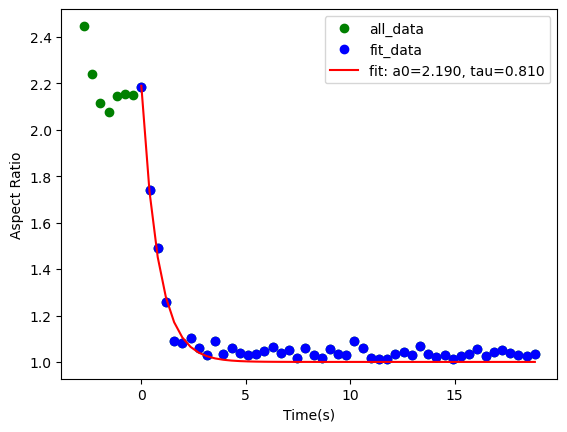

PolyPFusion_tifFiles/20240608_66_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_276-310.tif


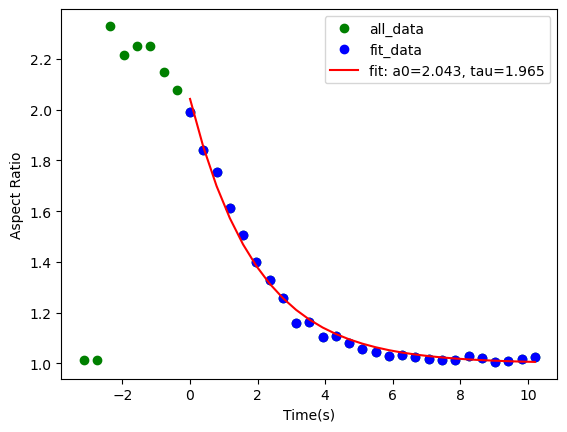

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_47-96.tif


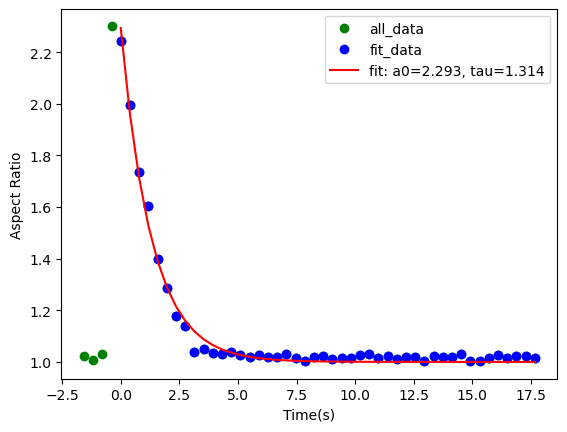

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_170-219.tif


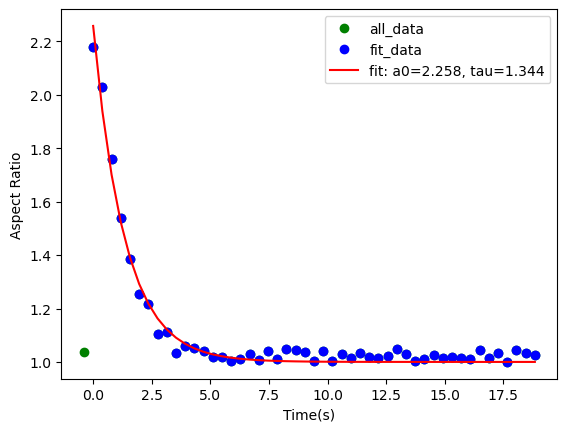

PolyPFusion_tifFiles/20240608_36_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_113-159.tif


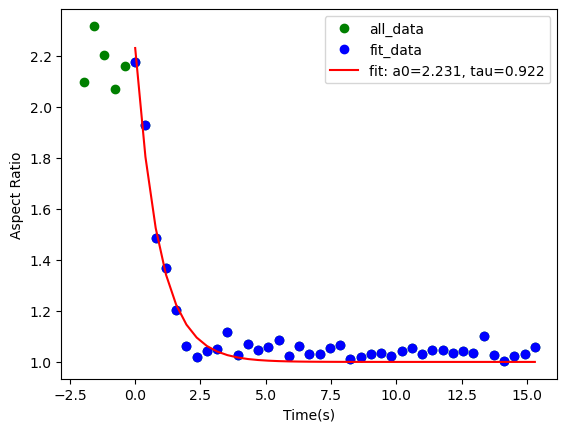

PolyPFusion_tifFiles/20240608_67_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_184-223.tif


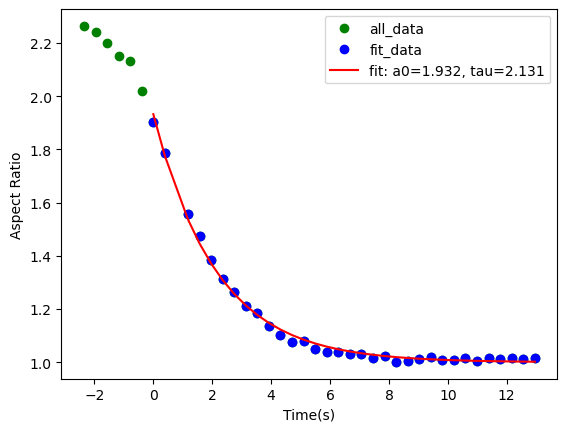

PolyPFusion_tifFiles/20240608_66_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_214-310.tif


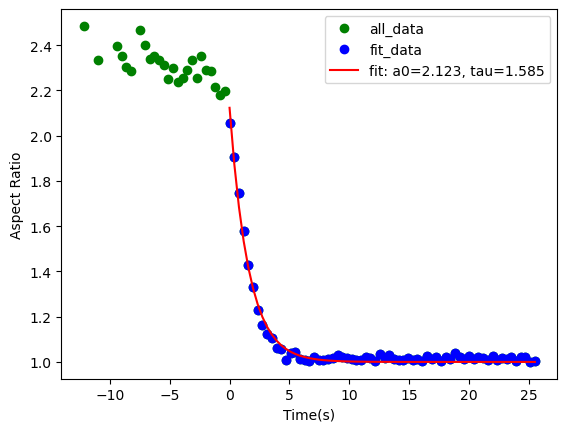

PolyPFusion_tifFiles/20240608_81_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_275-310.tif


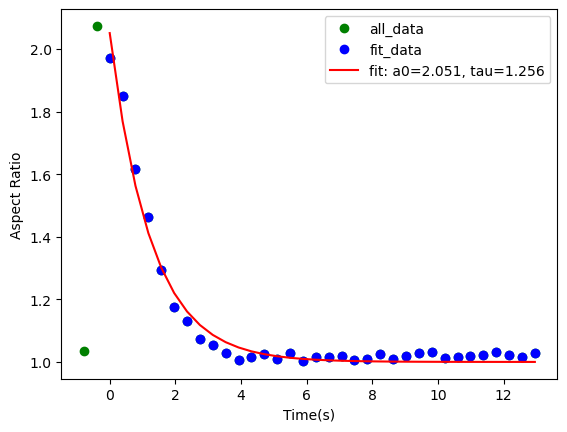

PolyPFusion_tifFiles/20240608_77_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_213-272.tif


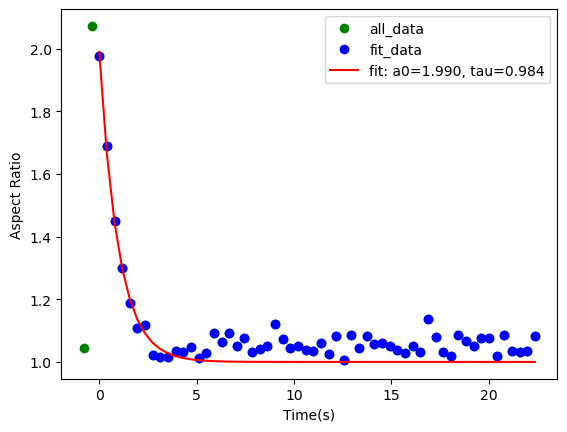

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_178-237.tif


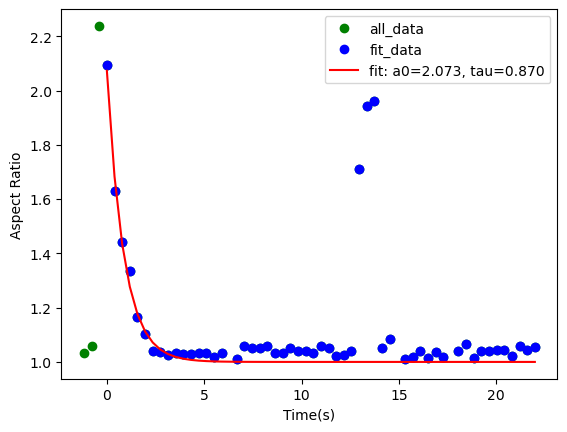

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_95-144.tif


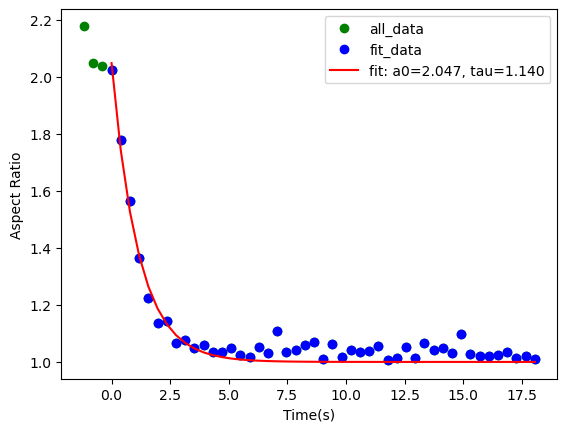

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_170-219.tif


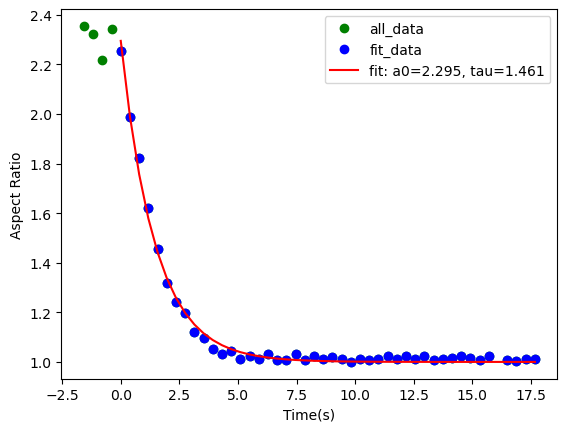

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_200-249.tif


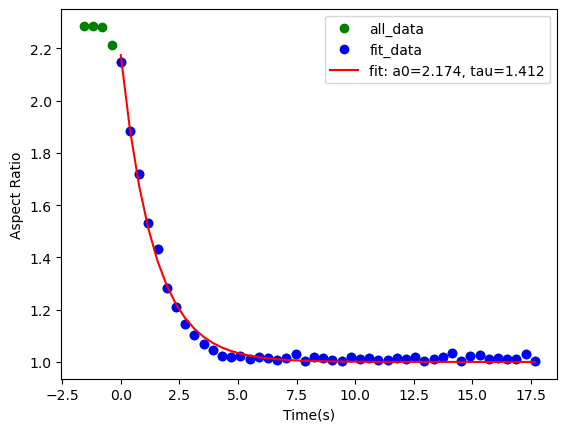

PolyPFusion_tifFiles/20240608_72_O_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_232-291.tif


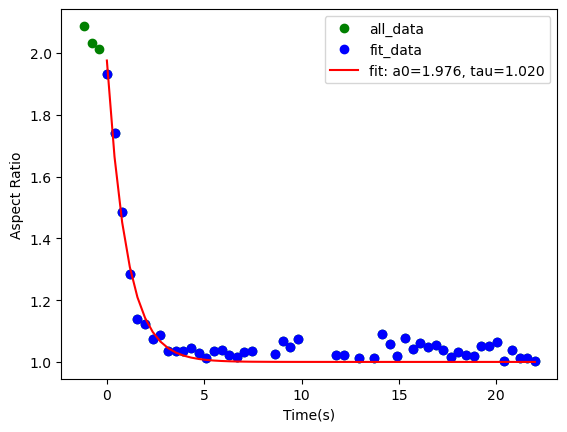

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_294-310.tif


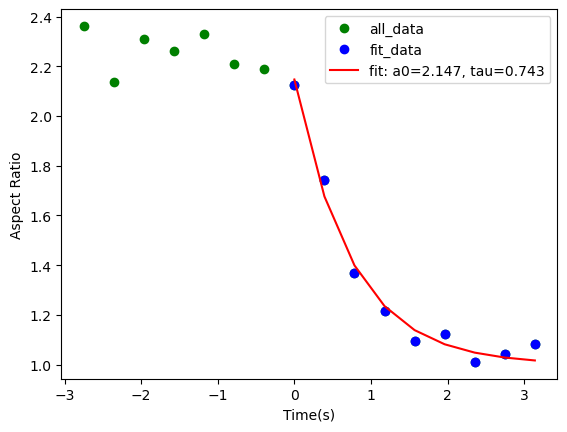

PolyPFusion_tifFiles/20240608_55_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_174-223.tif


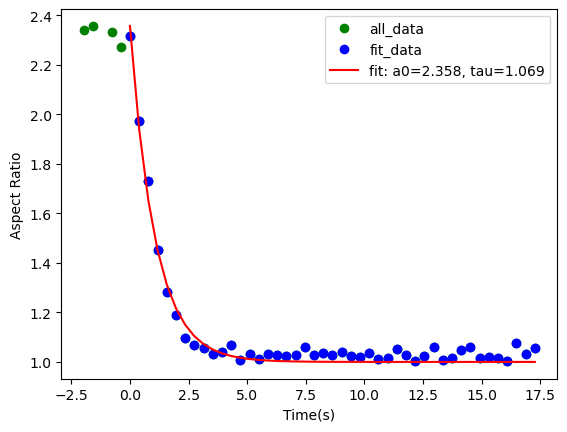

PolyPFusion_tifFiles/20240608_67_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_153-202.tif


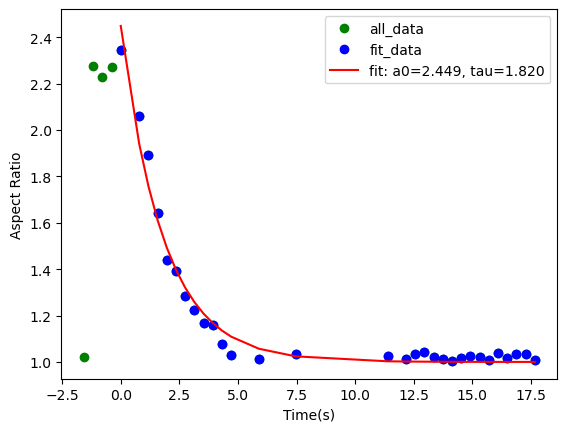

PolyPFusion_tifFiles/20240608_97_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_202-242.tif


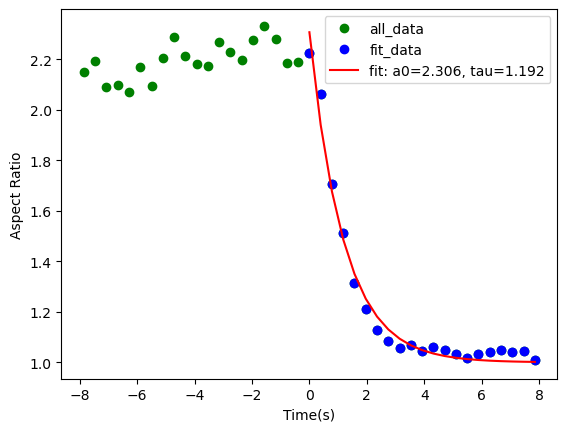

PolyPFusion_tifFiles/20240608_36_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_121-154.tif


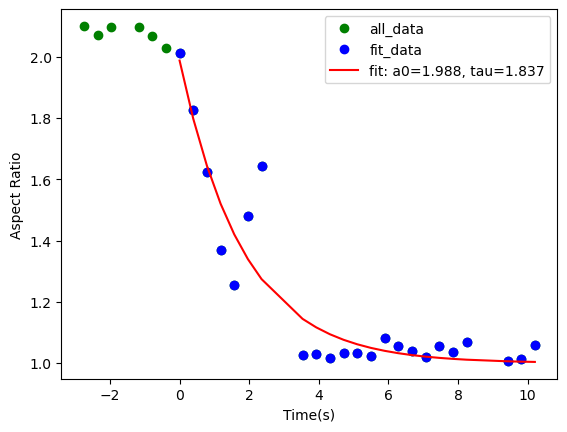

PolyPFusion_tifFiles/20240608_77_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_189-259.tif
no zero found
no zero found


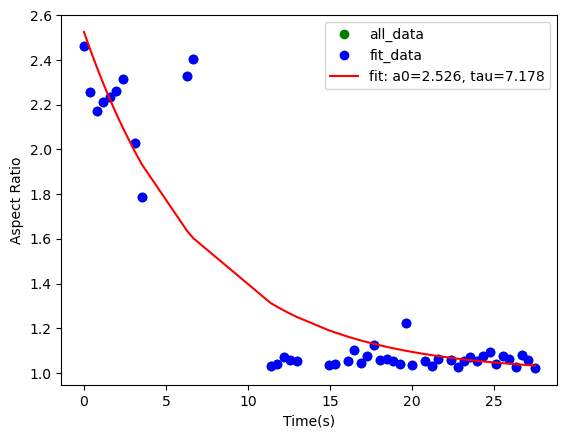

PolyPFusion_tifFiles/20240608_97_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_213-252.tif


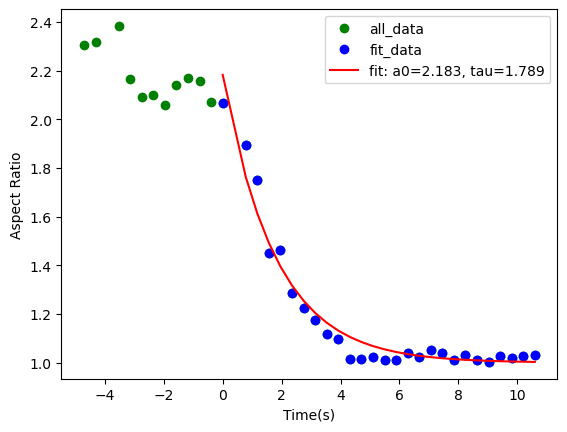

PolyPFusion_tifFiles/20240608_86_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_92-153.tif


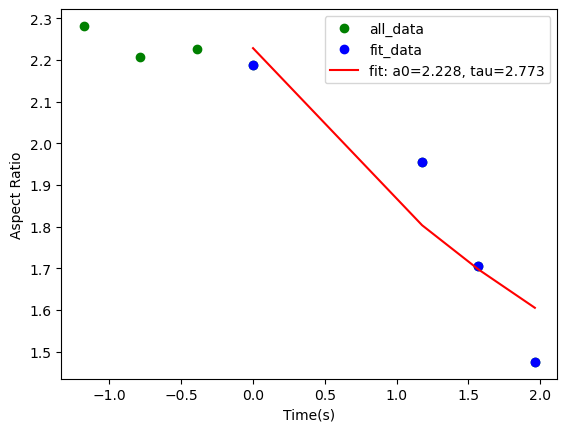

PolyPFusion_tifFiles/20240608_87_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_188-232.tif


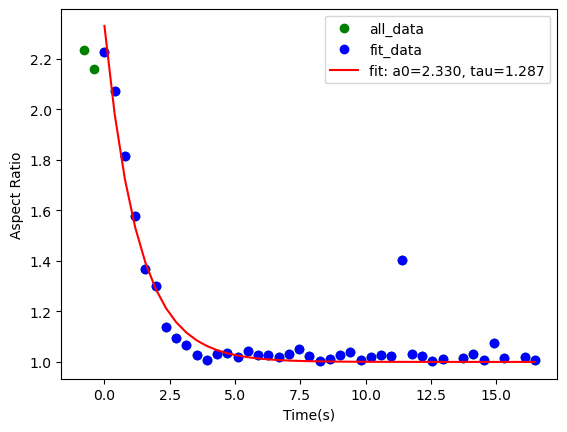

PolyPFusion_tifFiles/20240608_87_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_192-251.tif


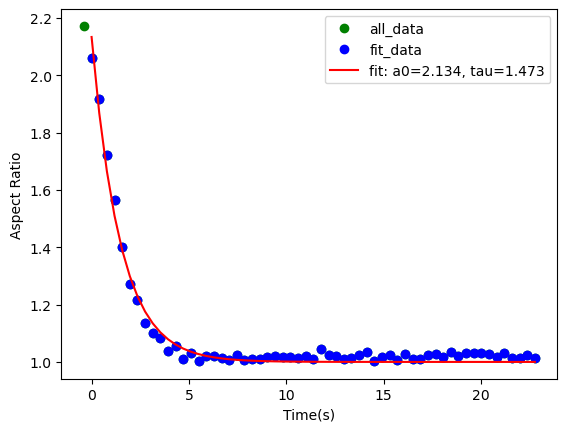

PolyPFusion_tifFiles/20240608_56_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_72-121.tif


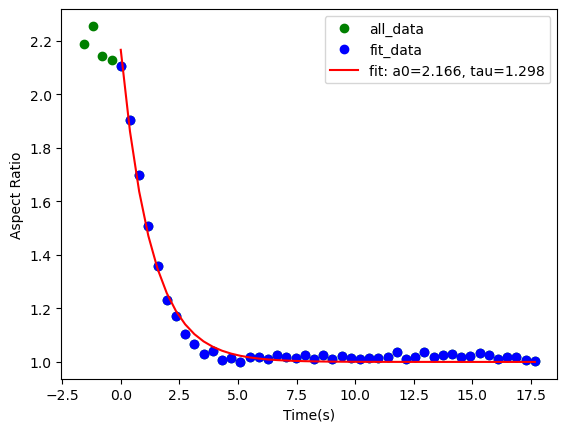

PolyPFusion_tifFiles/20240608_80_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_246-305.tif


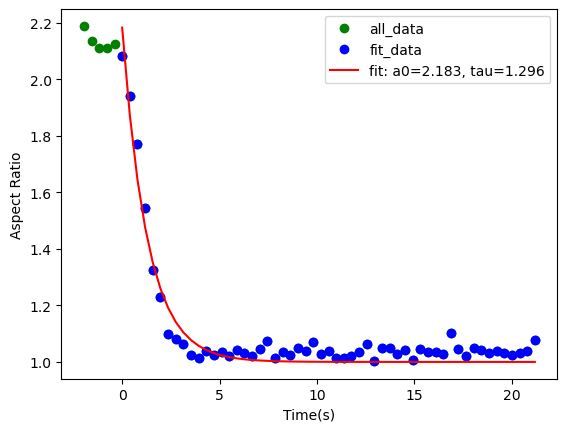

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_205-254.tif


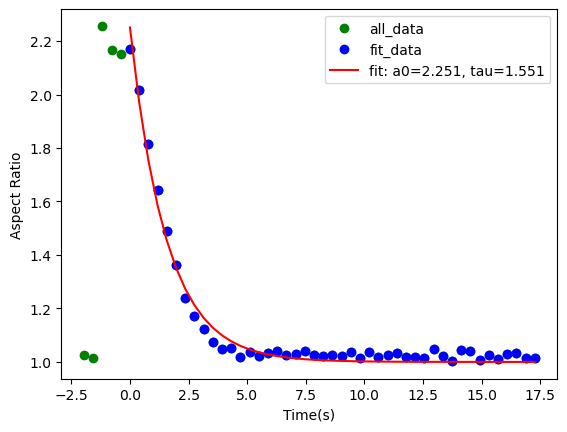

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_237-296.tif


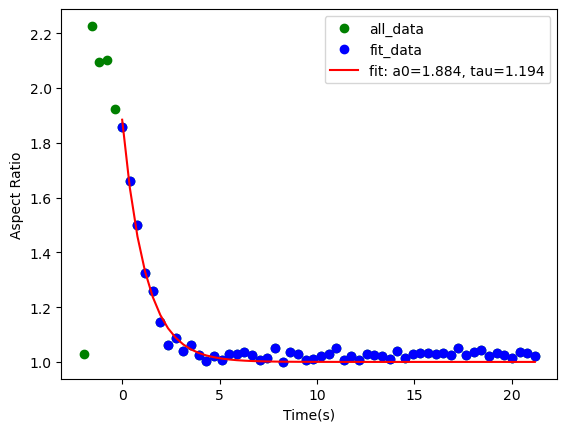

PolyPFusion_tifFiles/20240608_67_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_96-145.tif


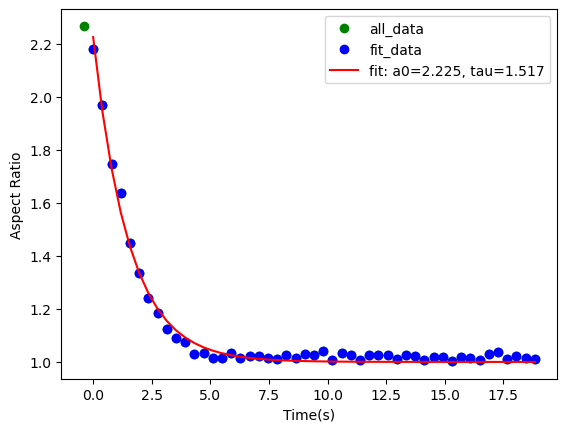

PolyPFusion_tifFiles/20240608_81_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_250-310.tif


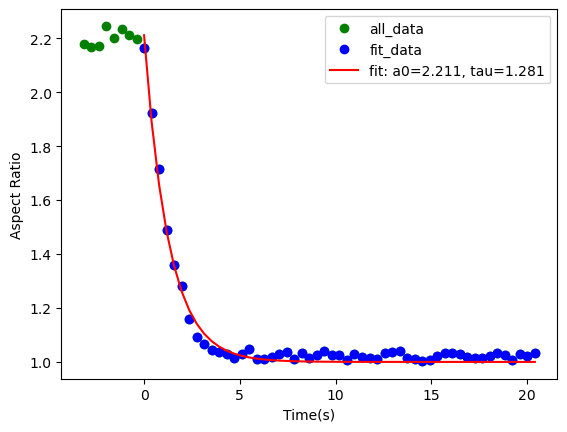

PolyPFusion_tifFiles/20240608_61_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_35-84.tif


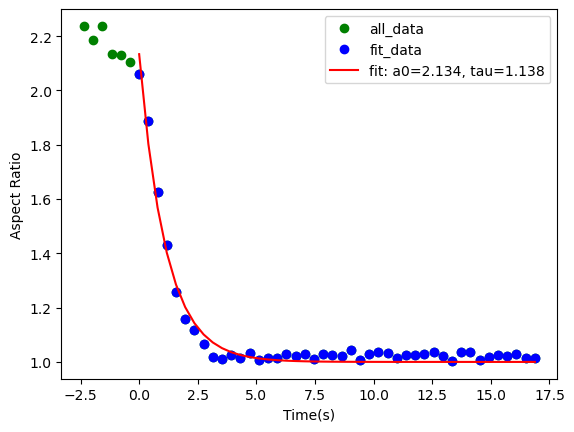

PolyPFusion_tifFiles/20240608_23_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_60-109.tif


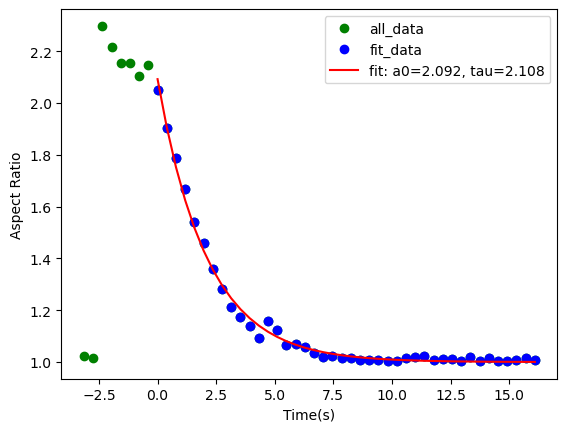

PolyPFusion_tifFiles/20240608_57_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_135-184.tif


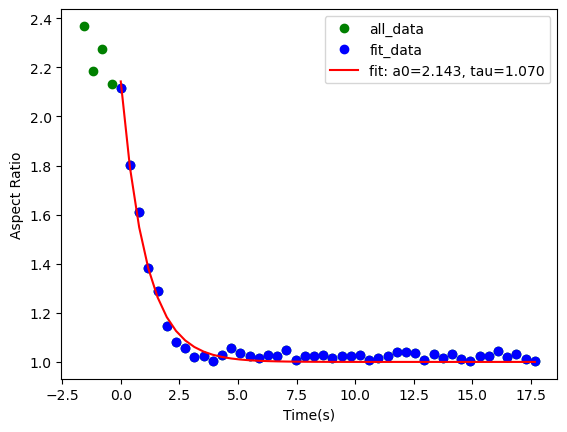

PolyPFusion_tifFiles/20240608_61_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_129-178.tif


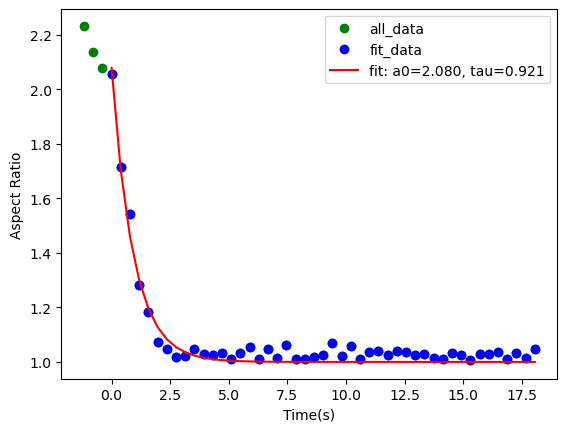

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_225-274.tif


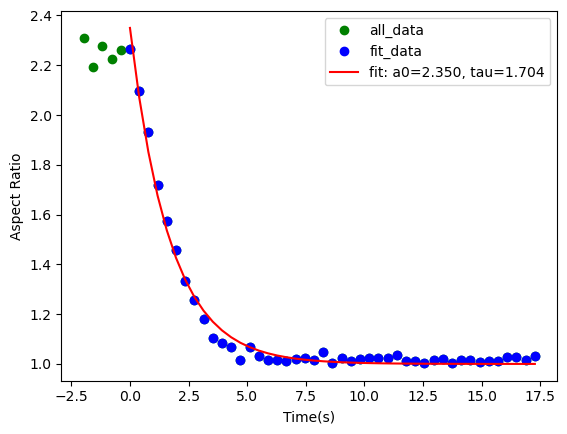

PolyPFusion_tifFiles/20240608_96_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_191-232.tif


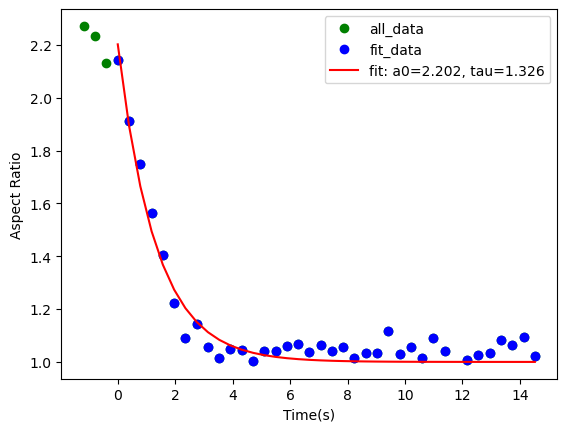

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_157-206.tif


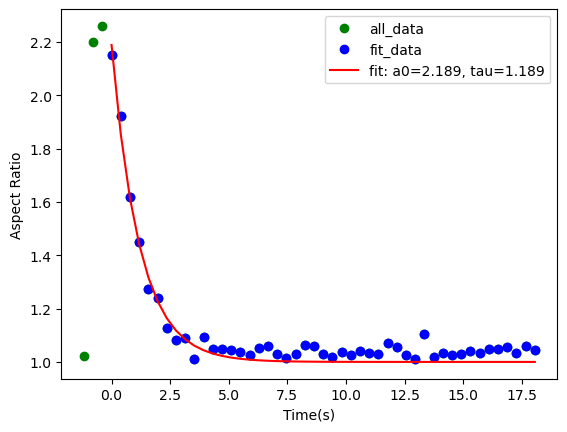

PolyPFusion_tifFiles/20240608_66_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_132-183.tif


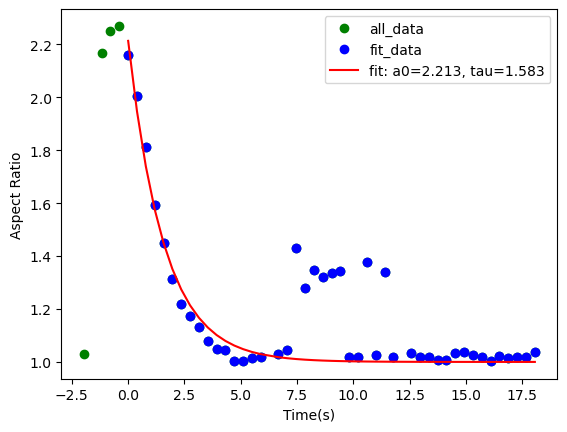

PolyPFusion_tifFiles/20240608_23_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_85-134.tif


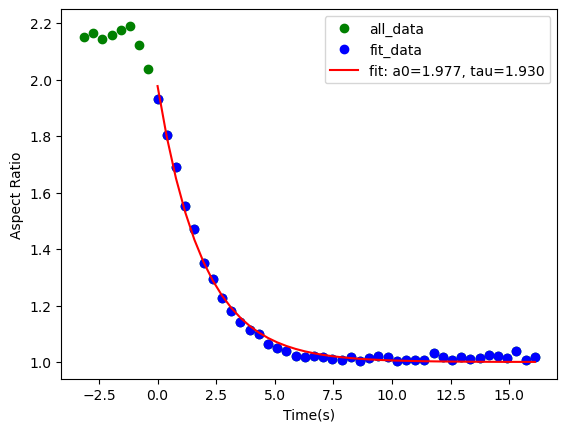

PolyPFusion_tifFiles/20240608_56_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_135-184.tif


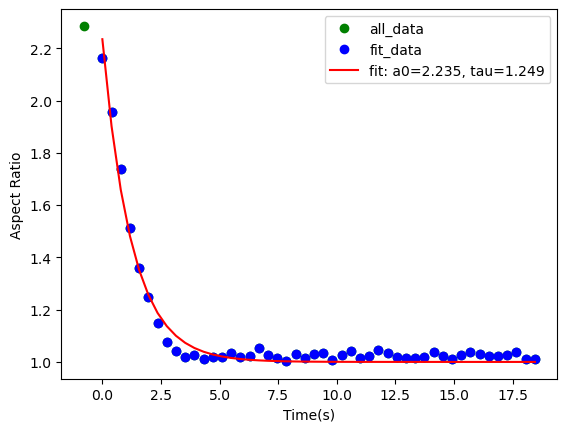

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_255-304.tif


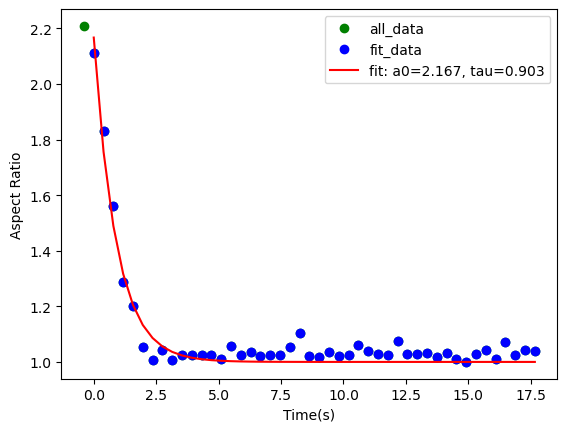

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_41-80.tif


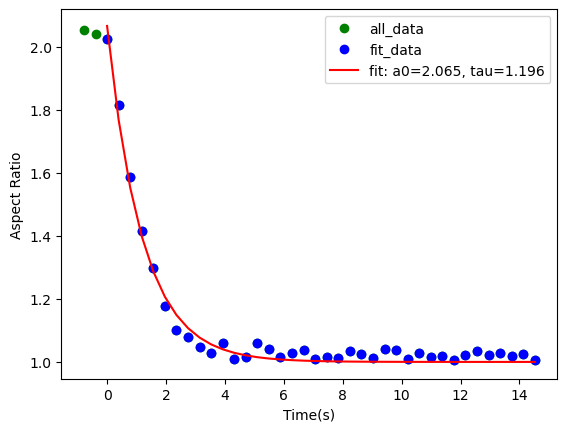

PolyPFusion_tifFiles/20240608_56_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_197-256.tif


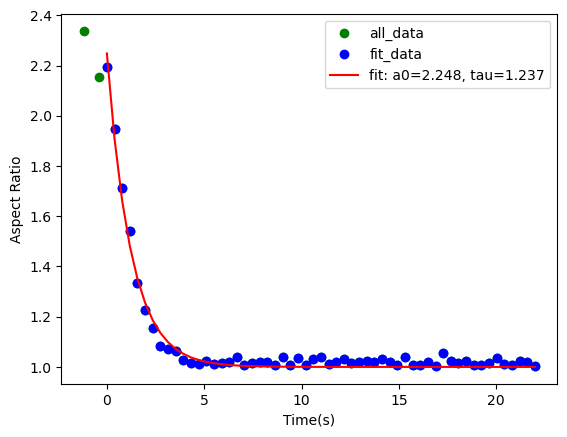

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_257-310.tif


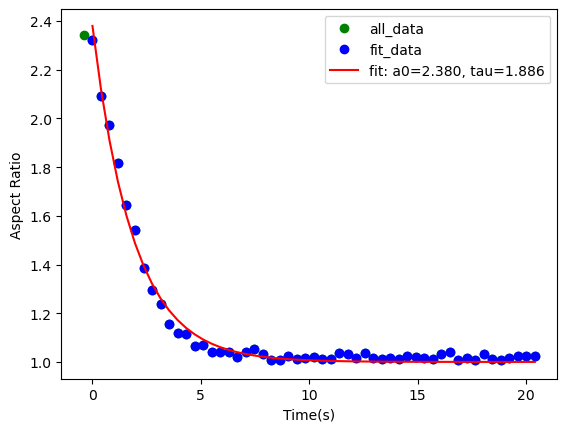

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_186-255.tif


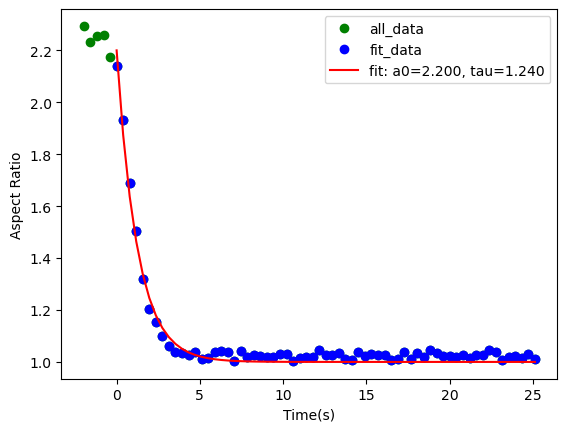

PolyPFusion_tifFiles/20240608_96_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_143-168.tif


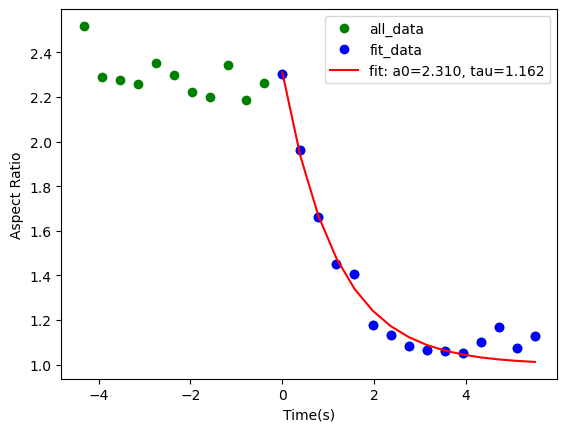

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_220-269.tif


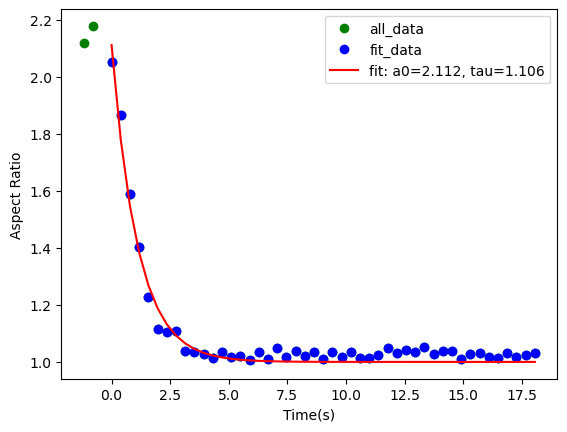

PolyPFusion_tifFiles/20240608_62_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_280-310.tif


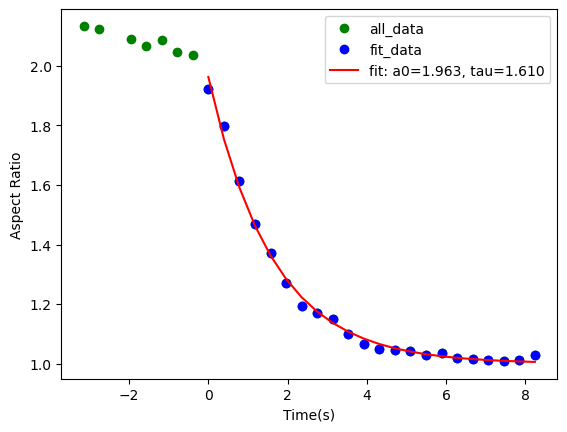

PolyPFusion_tifFiles/20240608_62_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_60-119.tif


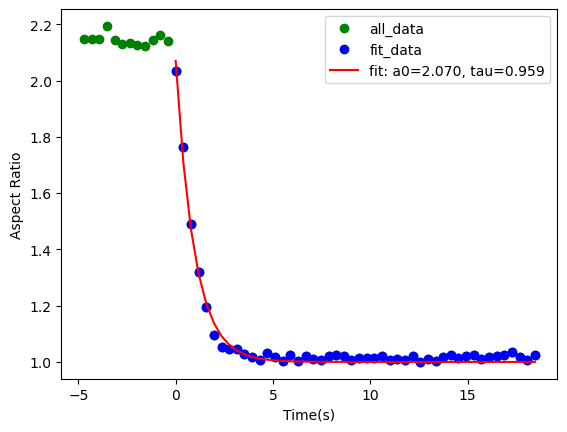

PolyPFusion_tifFiles/20240608_37_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_125-174.tif


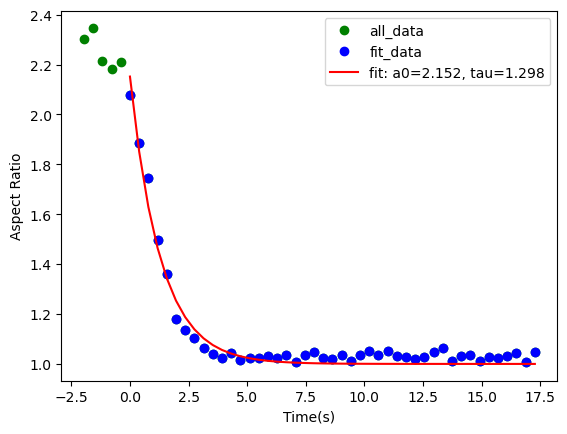

PolyPFusion_tifFiles/20240608_82_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_273-310.tif


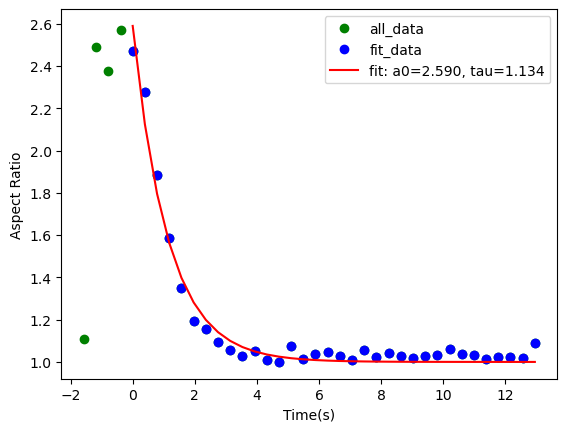

PolyPFusion_tifFiles/20240608_55_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_140-189.tif


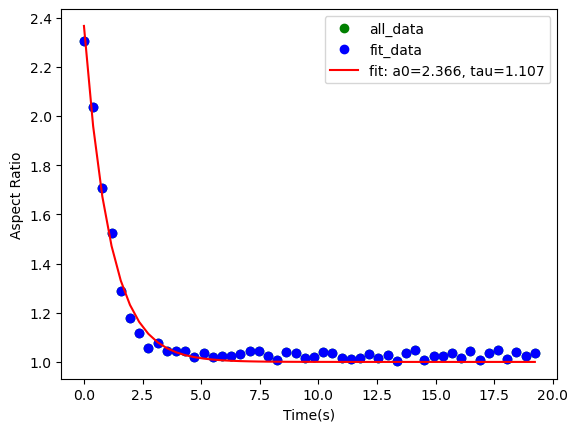

PolyPFusion_tifFiles/20240608_23_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_79-128.tif


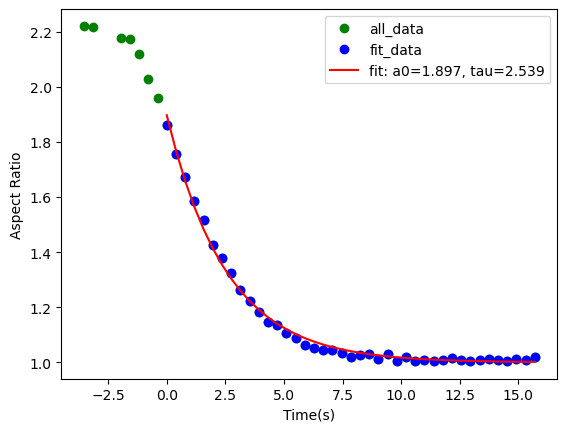

PolyPFusion_tifFiles/20240608_62_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_75-124.tif


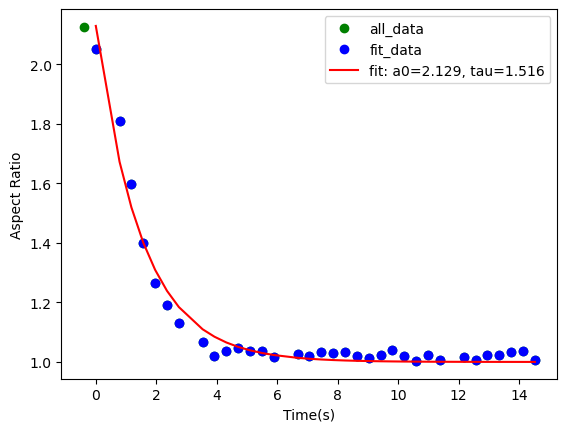

PolyPFusion_tifFiles/20240608_62_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_144-193.tif


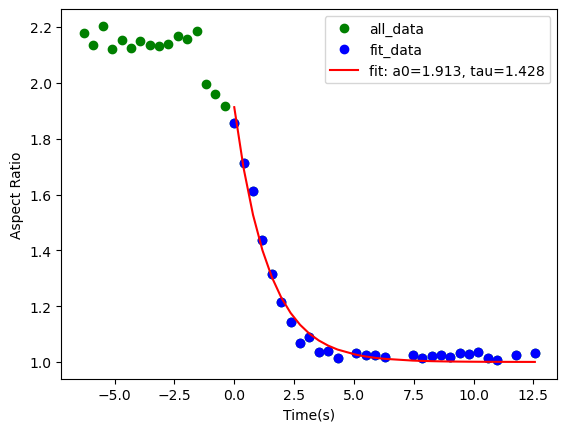

PolyPFusion_tifFiles/20240608_97_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_189-211.tif


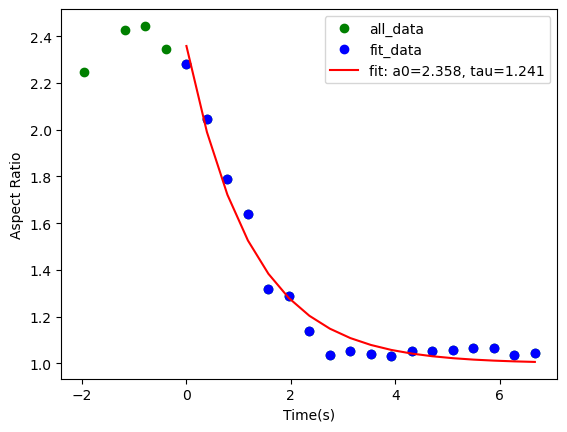

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_241-300.tif


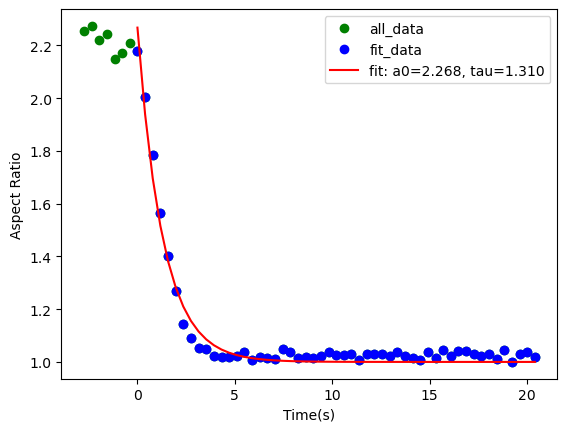

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_272-310.tif


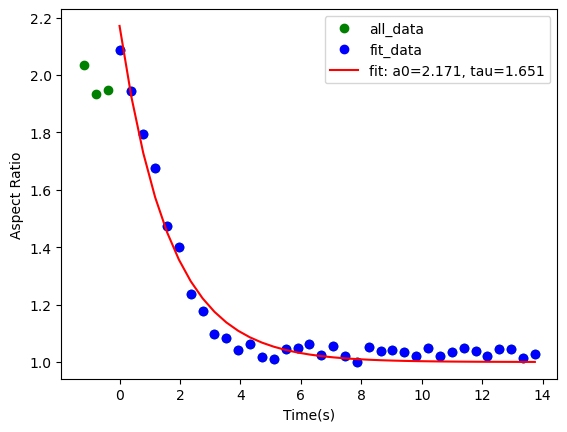

PolyPFusion_tifFiles/20240608_35_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_104-154.tif


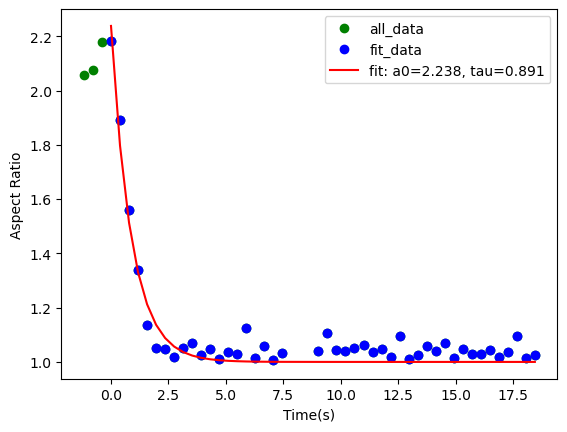

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_228-277.tif


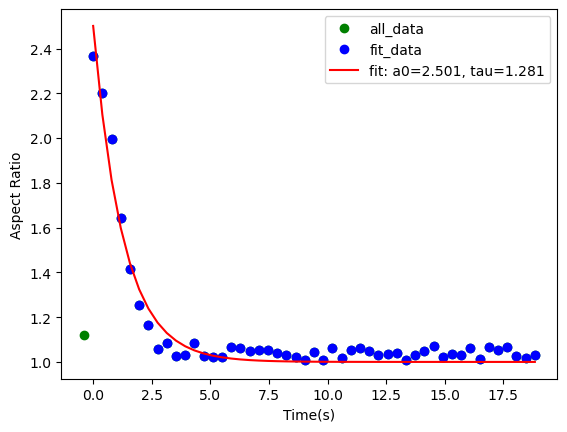

PolyPFusion_tifFiles/20240608_90_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_178-203.tif


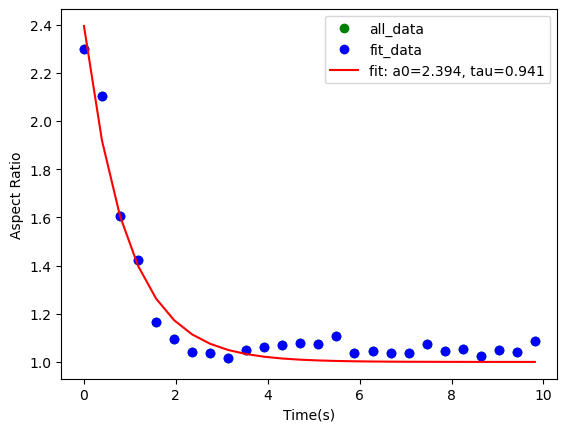

PolyPFusion_tifFiles/20240608_62_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_173-222.tif


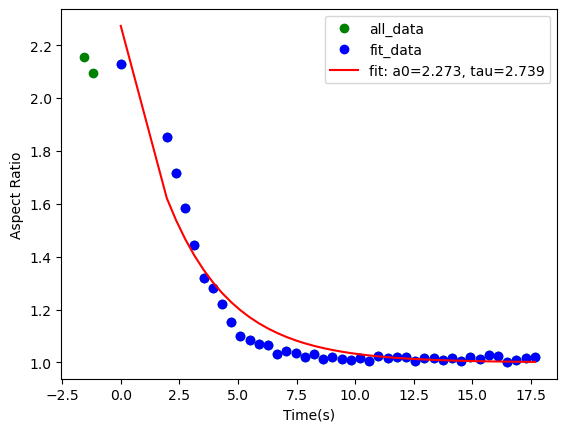

PolyPFusion_tifFiles/20240608_36_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_220-269.tif


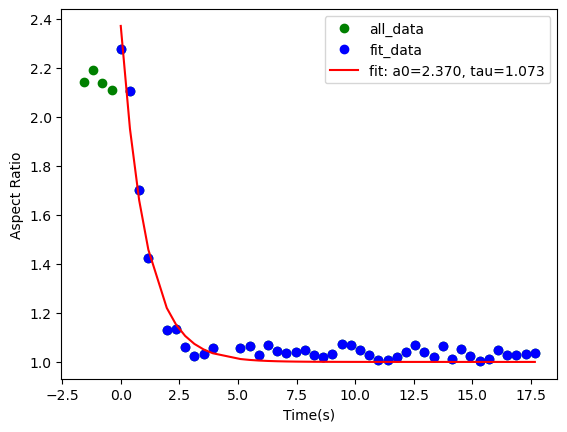

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_38-80.tif


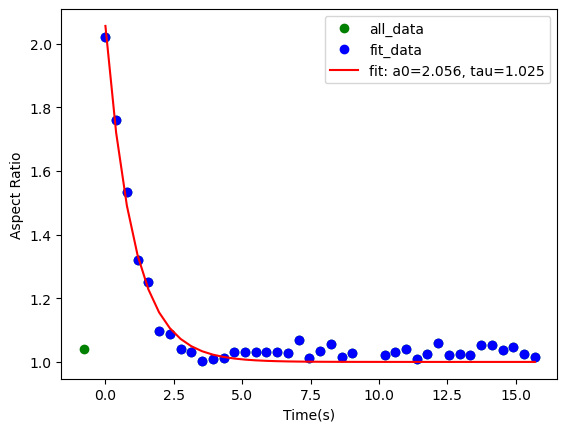

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_70-105.tif


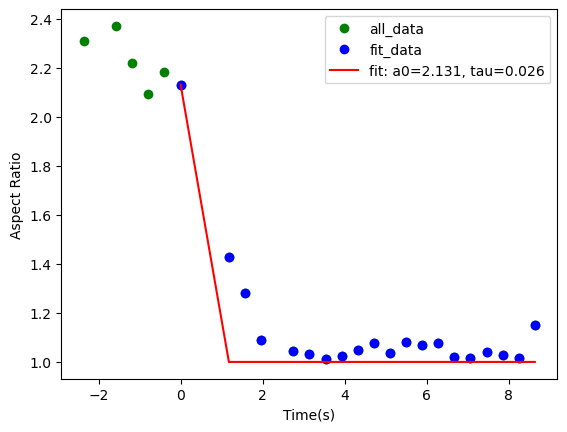

PolyPFusion_tifFiles/20240608_77_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_267-310.tif


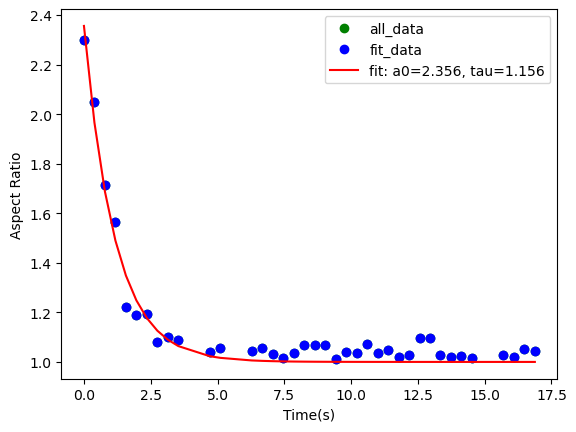

PolyPFusion_tifFiles/20240608_55_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_271-310.tif


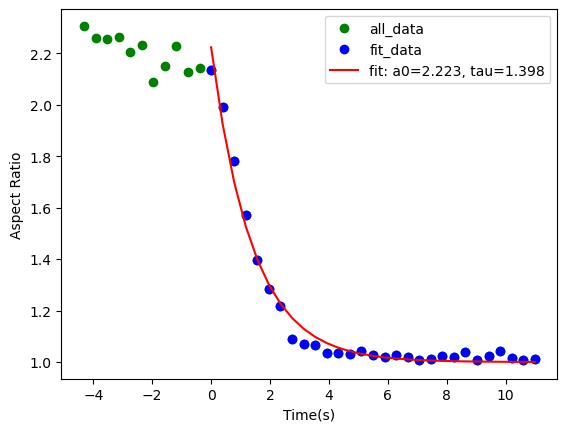

PolyPFusion_tifFiles/20240608_23_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_21-70.tif


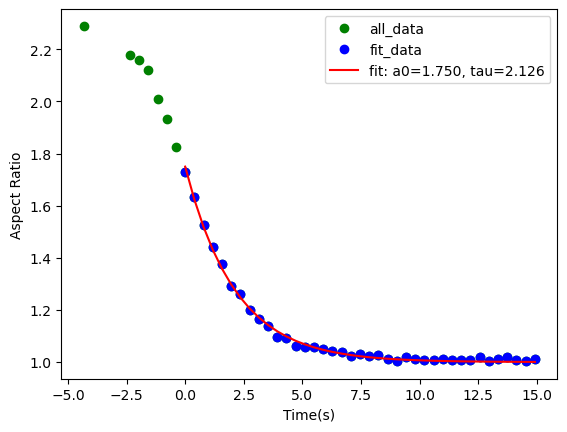

PolyPFusion_tifFiles/20240608_91_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_87-131.tif


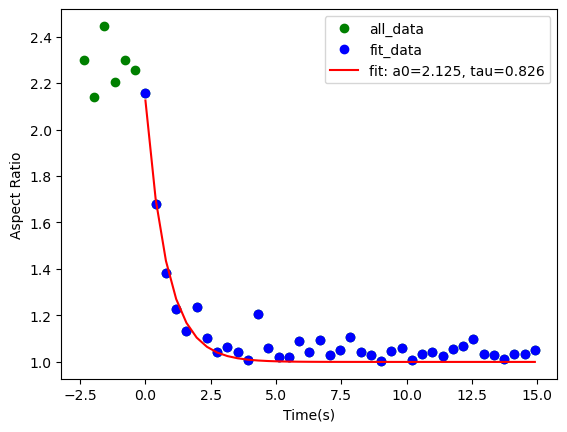

PolyPFusion_tifFiles/20240608_76_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_269-310.tif


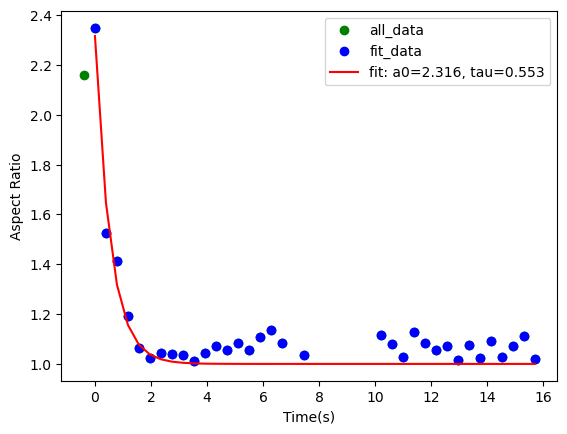

PolyPFusion_tifFiles/20240608_55_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_144-193.tif


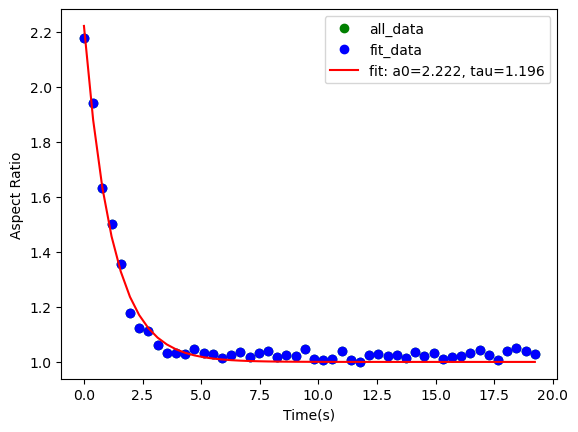

PolyPFusion_tifFiles/20240608_81_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_222-281.tif


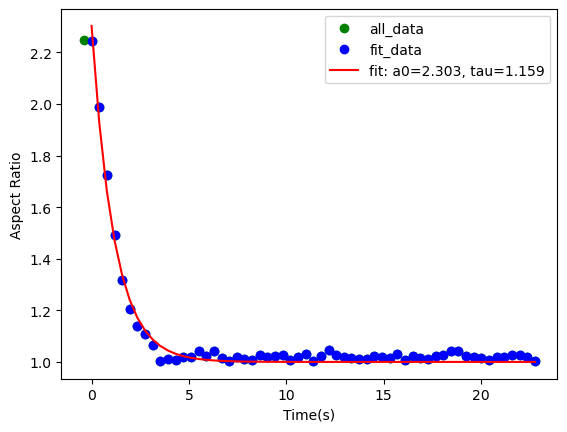

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_239-288.tif


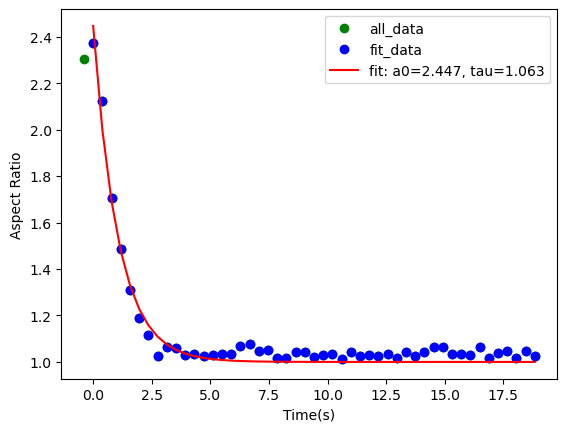

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_235-284.tif


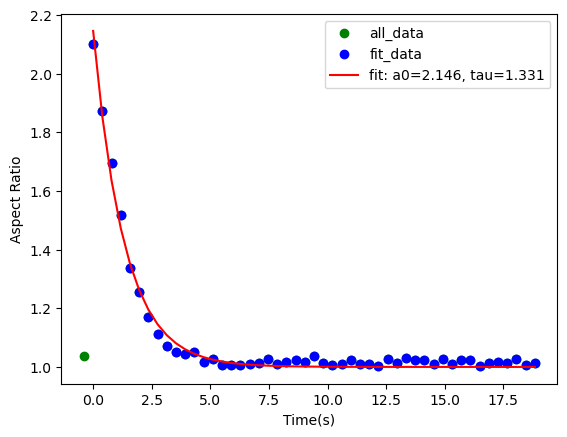

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_180-219.tif


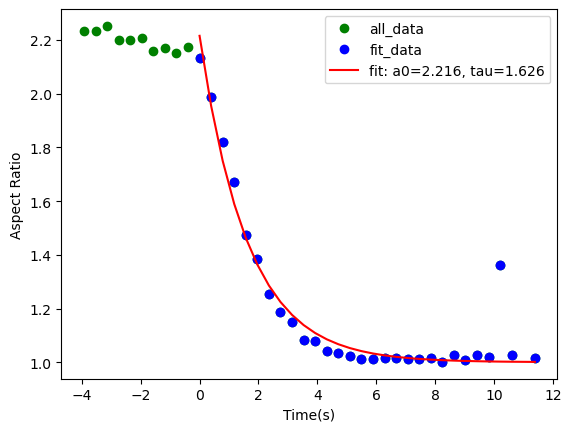

PolyPFusion_tifFiles/20240608_57_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_113-162.tif


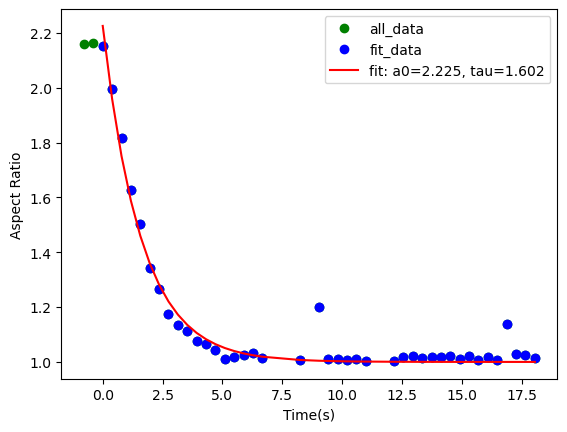

PolyPFusion_tifFiles/20240608_86_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_141-210.tif


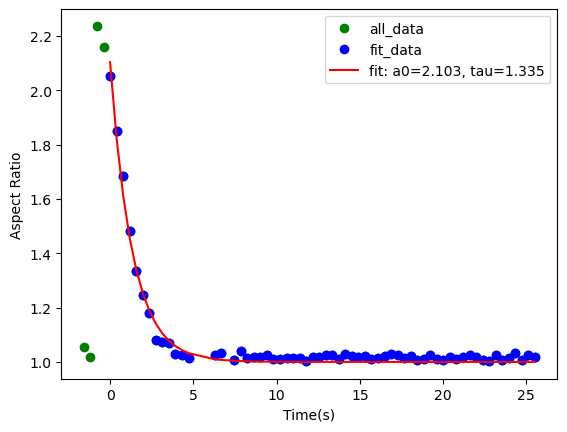

PolyPFusion_tifFiles/20240608_81_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_245-310.tif


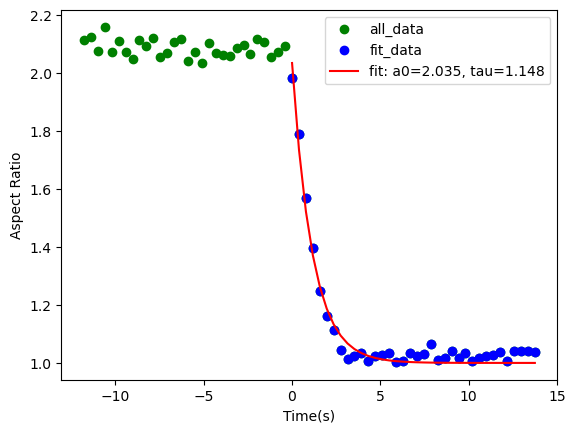

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_283-310.tif


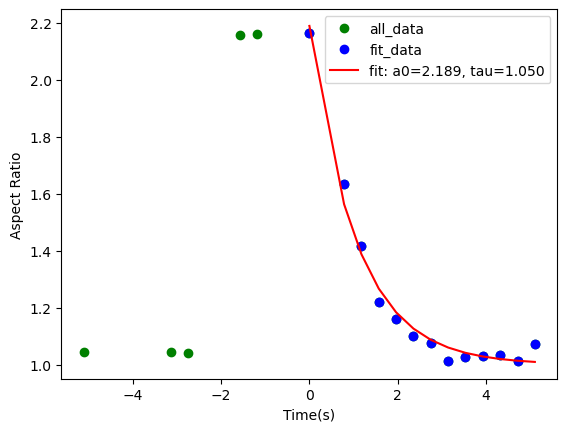

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_56-105.tif


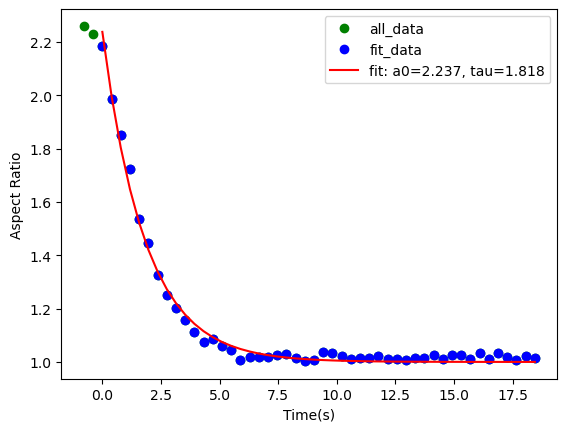

PolyPFusion_tifFiles/20240608_55_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_180-205.tif


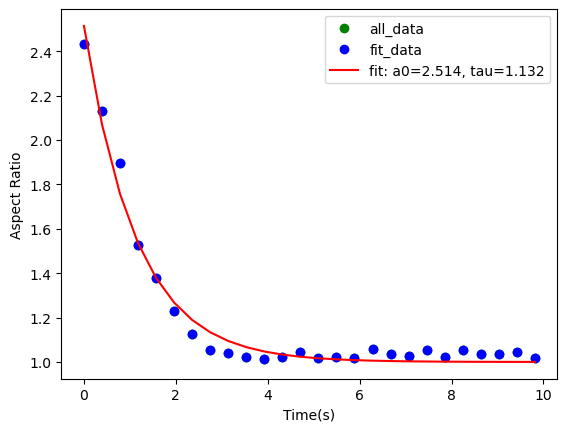

PolyPFusion_tifFiles/20240608_80_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_228-307.tif


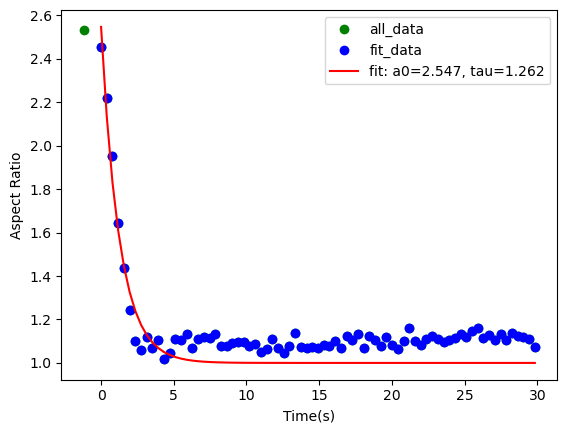

PolyPFusion_tifFiles/20240608_77_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_291-310.tif


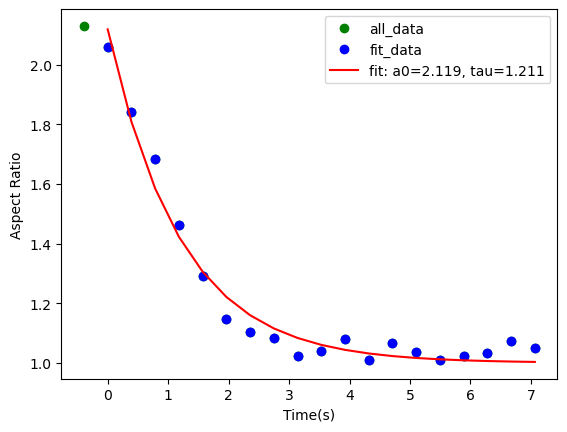

PolyPFusion_tifFiles/20240608_86_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_286-310.tif


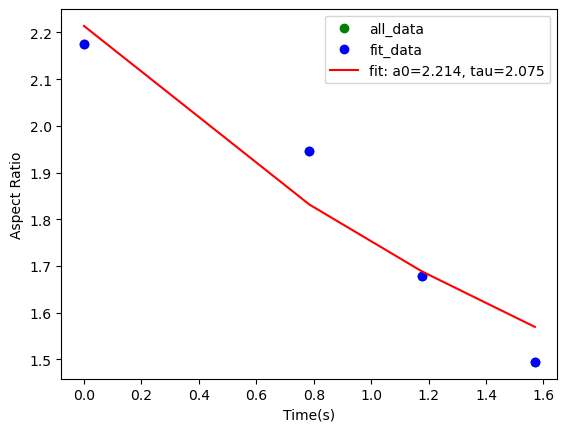

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_145-177.tif
no zero found
no zero found


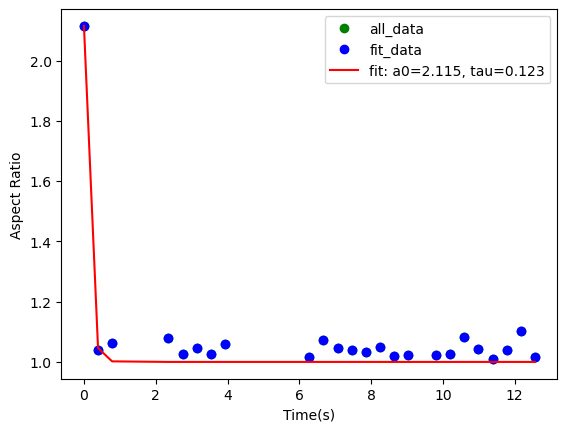

PolyPFusion_tifFiles/20240608_36_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_116-175.tif


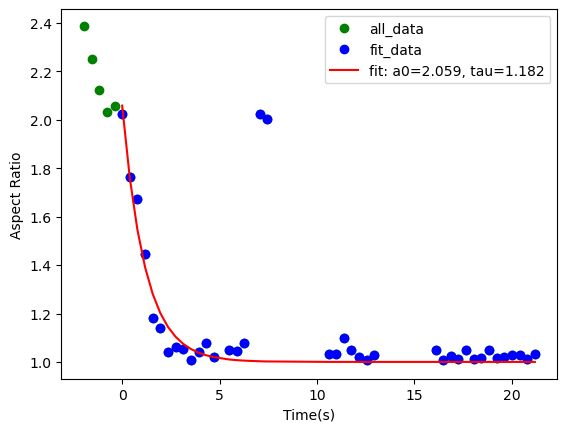

PolyPFusion_tifFiles/20240608_60_M_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_148-197.tif


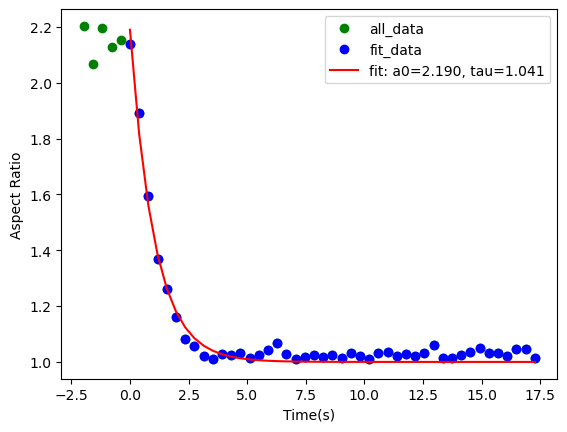

PolyPFusion_tifFiles/20240608_37_H_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_216-265.tif


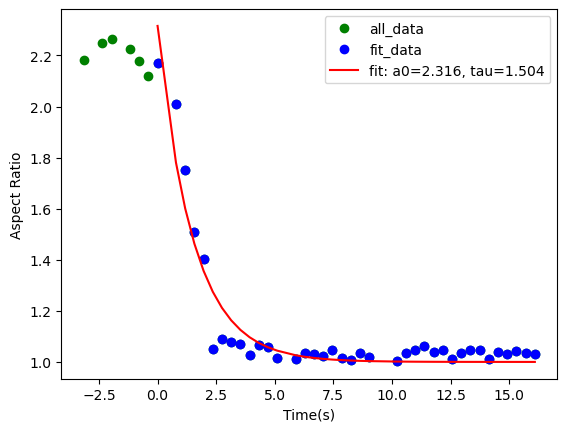

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_131-180.tif


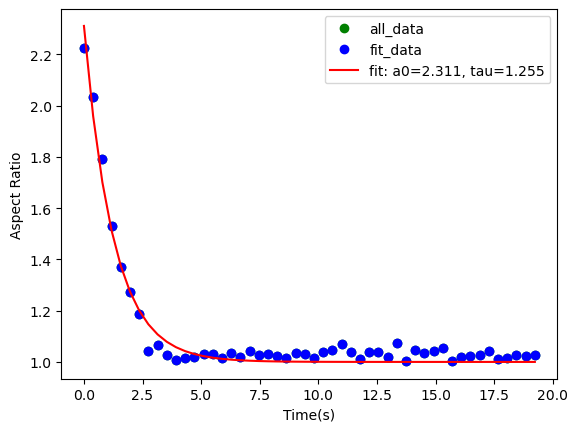

PolyPFusion_tifFiles/20240608_87_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_174-213.tif


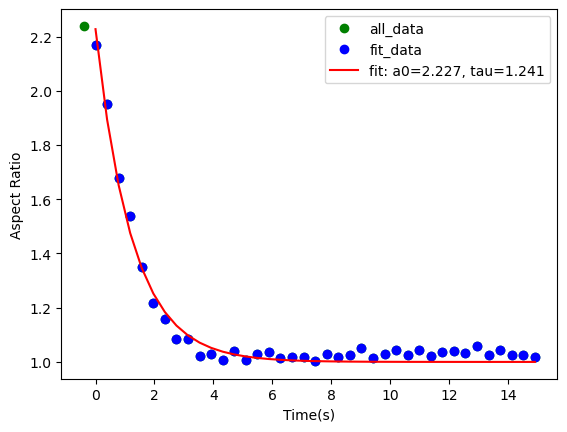

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_108-157.tif


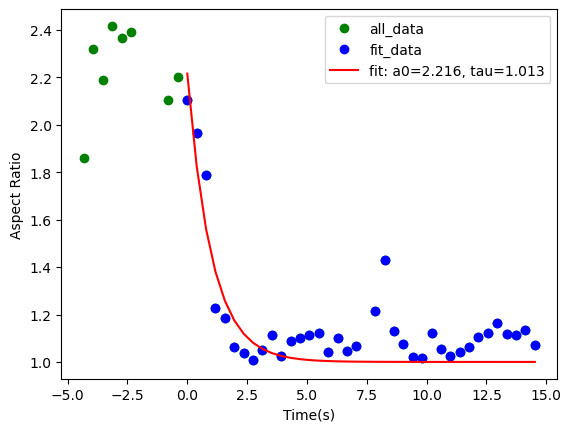

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_173-222.tif


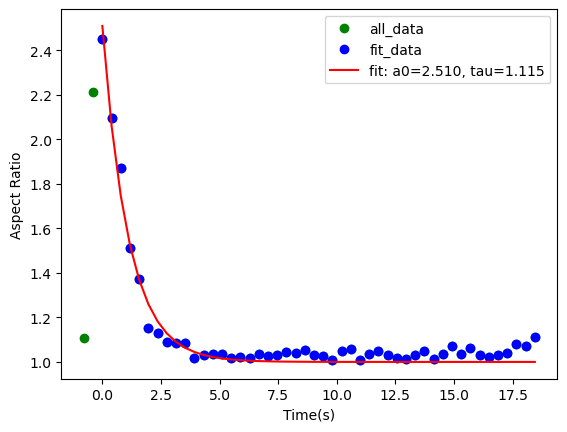

PolyPFusion_tifFiles/20240608_80_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_123-182.tif


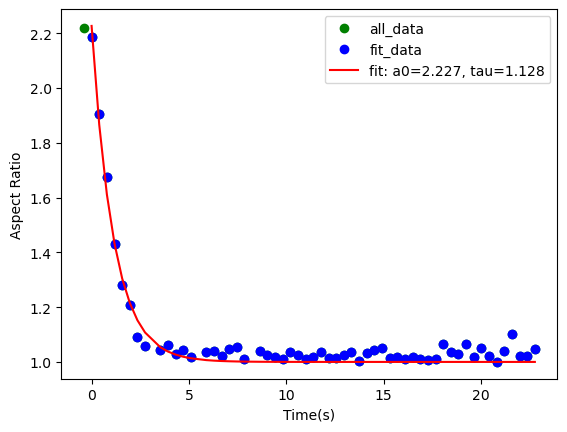

PolyPFusion_tifFiles/20240608_85_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_123-182.tif


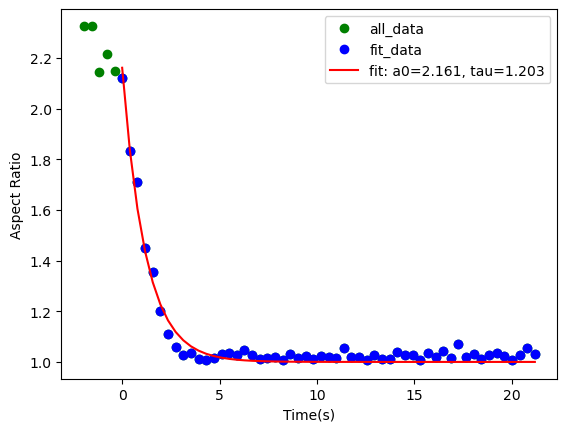

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_216-249.tif


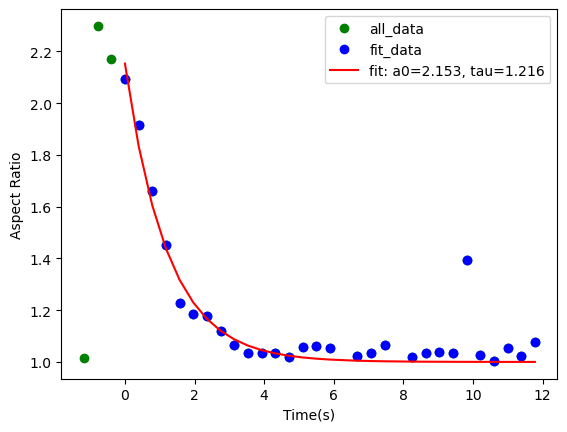

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_227-286.tif


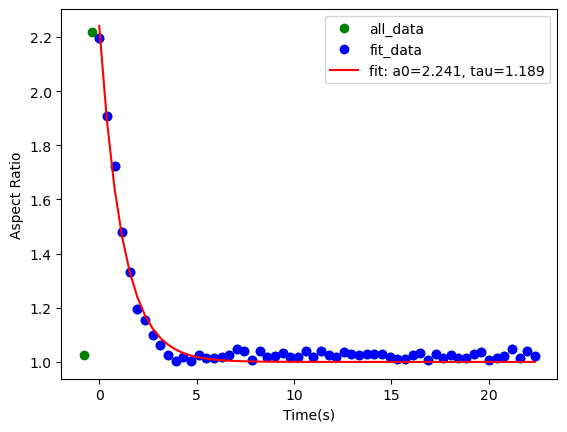

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_283-310.tif


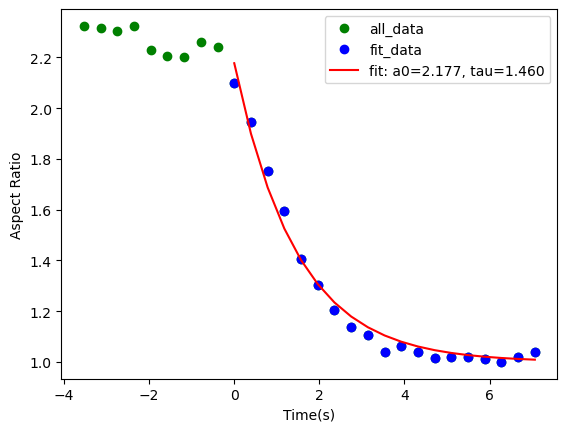

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_140-199.tif


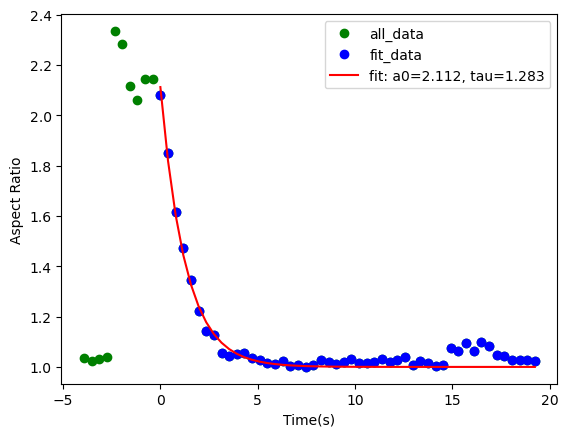

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_80-129.tif


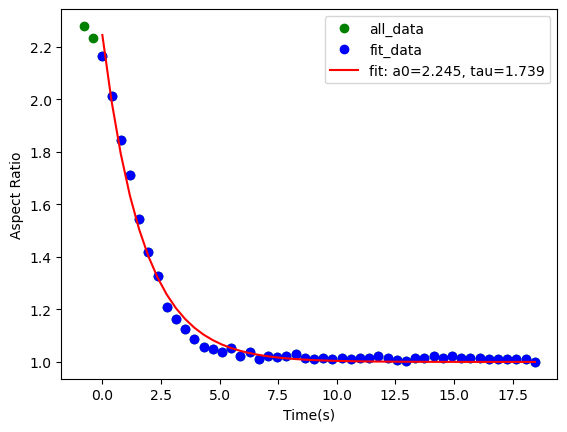

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_223-272.tif


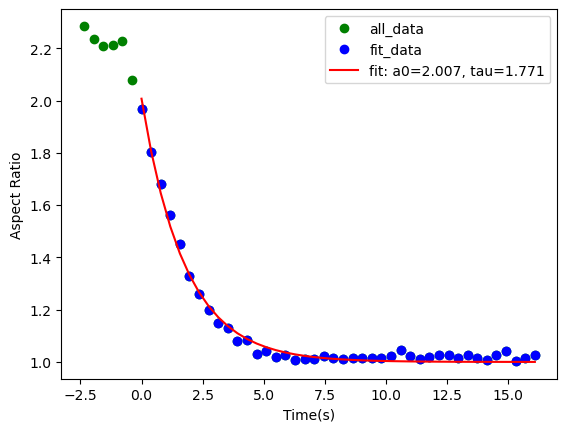

PolyPFusion_tifFiles/20240608_72_O_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_292-310.tif


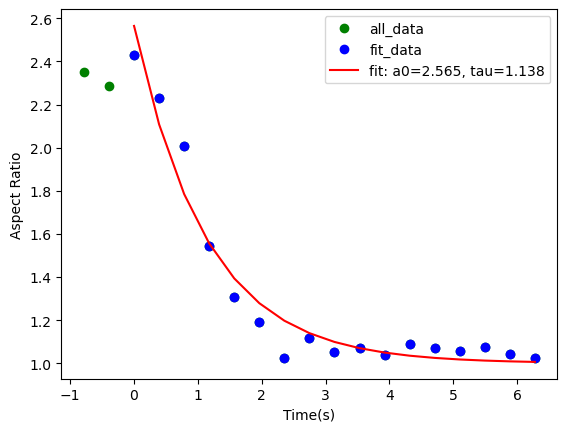

PolyPFusion_tifFiles/20240608_66_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_1-59.tif


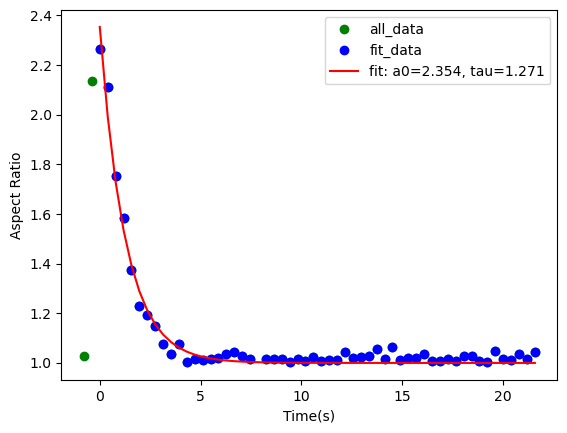

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_90-139.tif


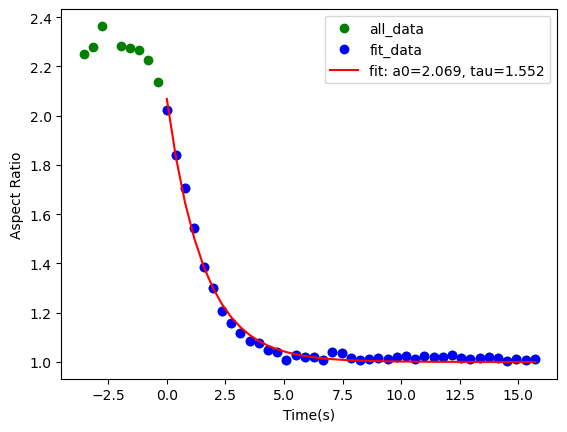

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_210-251.tif


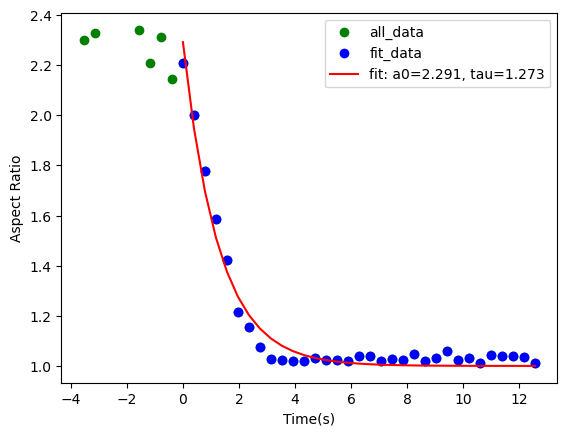

PolyPFusion_tifFiles/20240608_65_N_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_259-310.tif


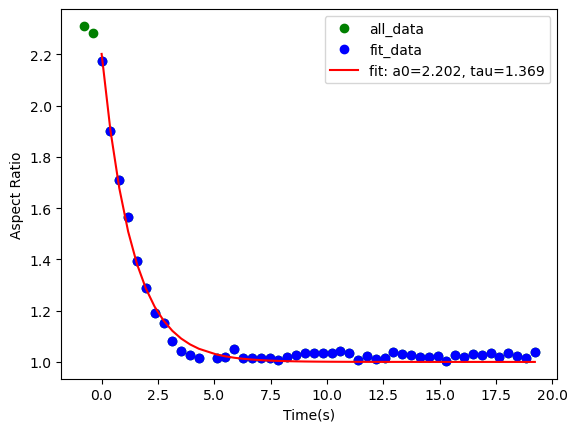

PolyPFusion_tifFiles/20240608_21_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_193-242.tif


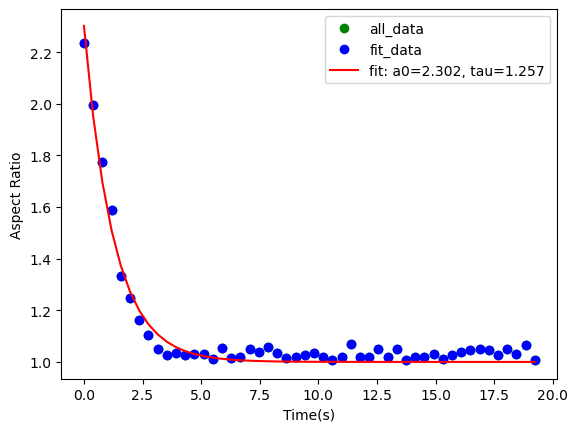

PolyPFusion_tifFiles/20240608_56_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_77-126.tif


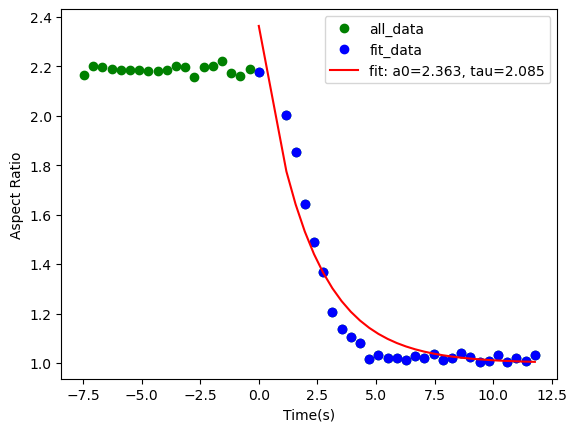

PolyPFusion_tifFiles/20240608_77_P_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_260-285.tif


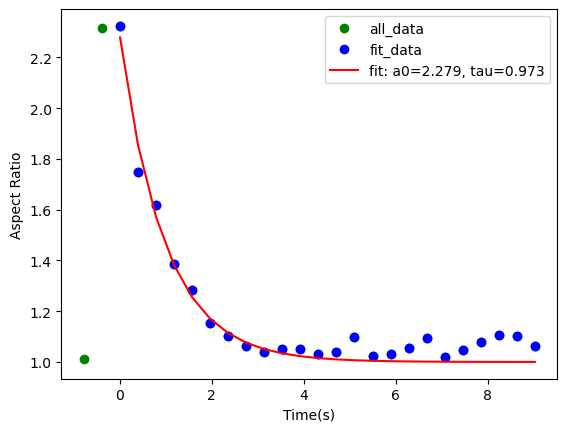

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_143-192.tif


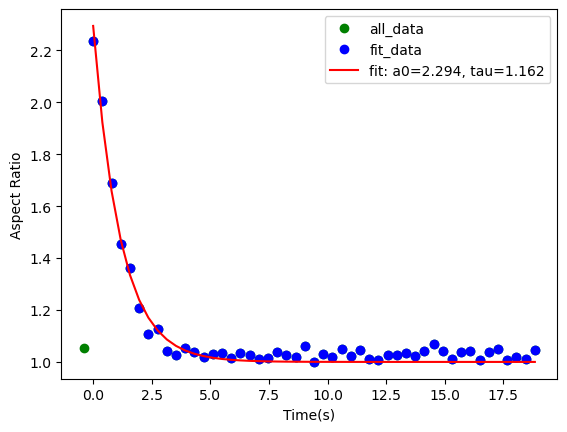

PolyPFusion_tifFiles/20240608_90_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_148-169.tif


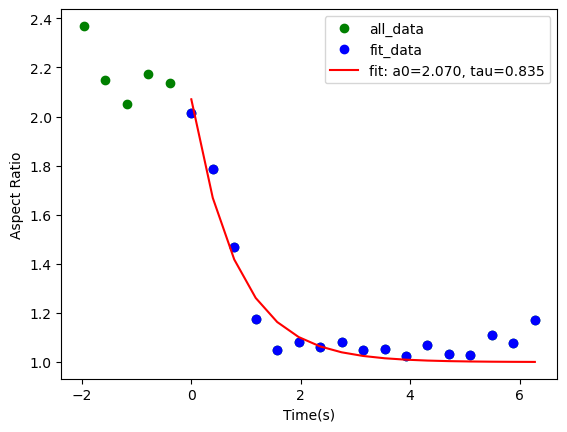

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_270-10.tif


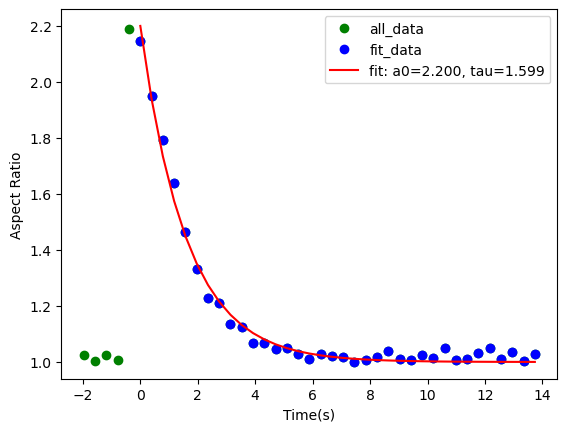

PolyPFusion_tifFiles/20240608_82_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_45-104.tif


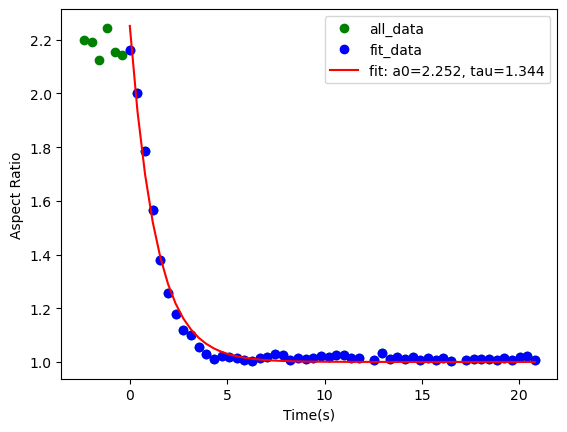

PolyPFusion_tifFiles/20240608_41_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_185-234.tif


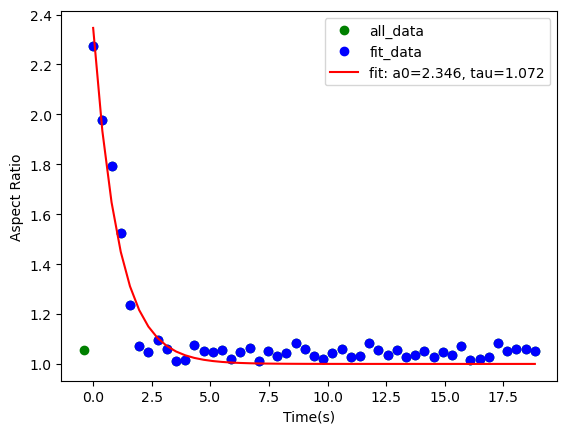

PolyPFusion_tifFiles/20240608_97_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_196-230.tif


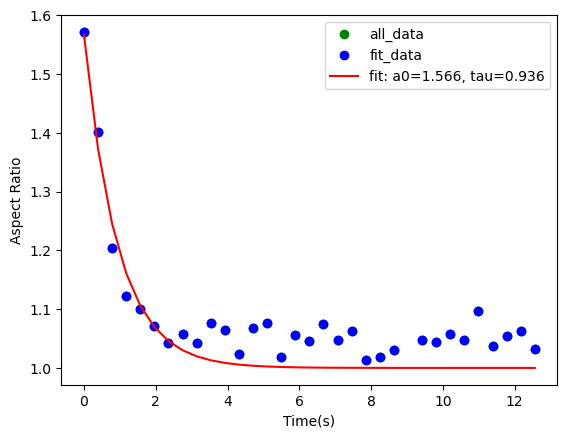

PolyPFusion_tifFiles/20240608_97_T_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_270-300.tif


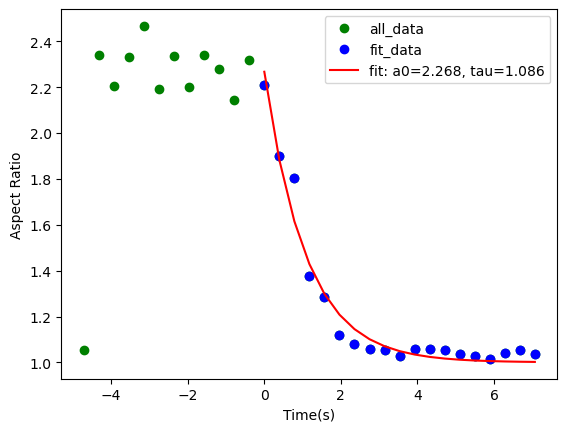

PolyPFusion_tifFiles/20240608_42_I_P700-1mgml_MgCl2-100mM_pUC19-100ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_50-109.tif


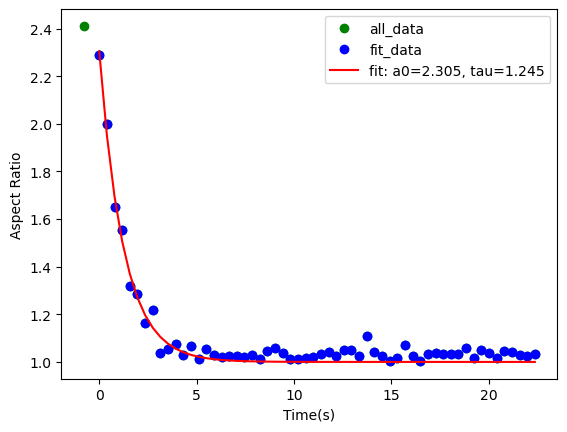

PolyPFusion_tifFiles/20240608_82_Q_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_50-109.tif


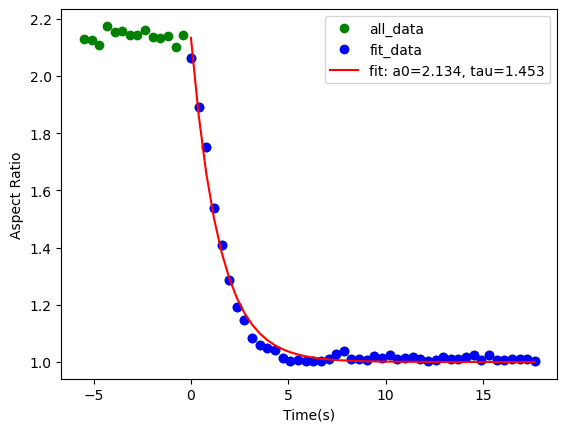

PolyPFusion_tifFiles/20240608_90_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_7.5min_213-244.tif


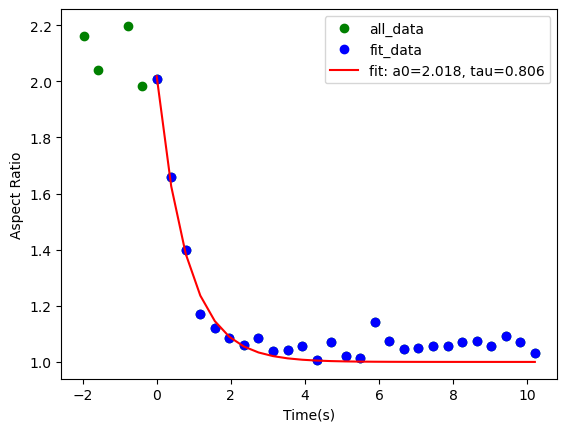

PolyPFusion_tifFiles/20240608_22_E_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_249-298.tif


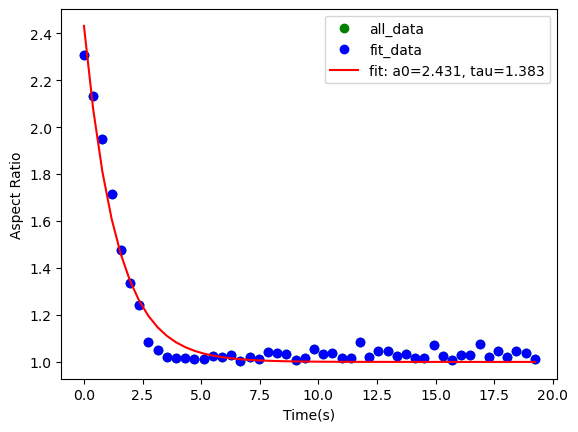

PolyPFusion_tifFiles/20240608_72_O_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_138-187.tif


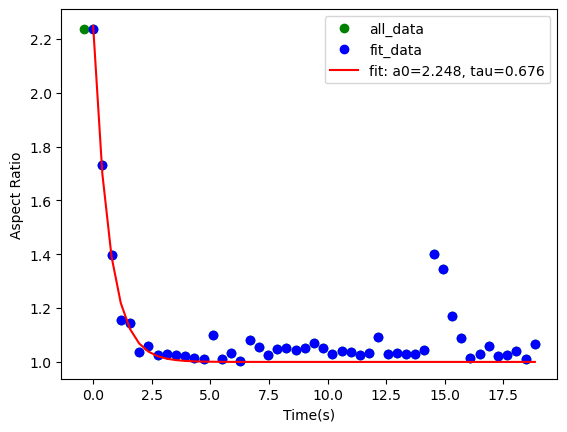

PolyPFusion_tifFiles/20240608_92_S_P700-1mgml_MgCl2-100mM_15kb-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_155-204.tif


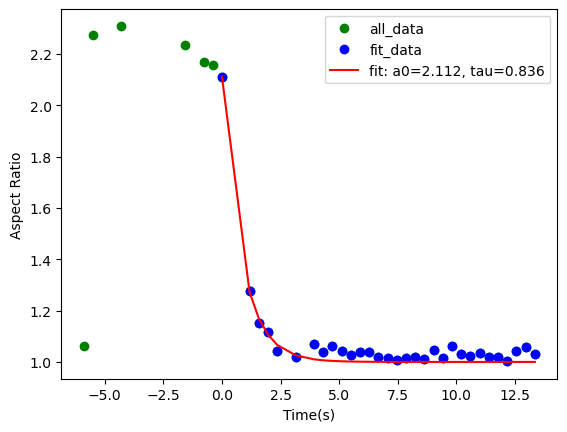

PolyPFusion_tifFiles/20240608_86_R_P700-1mgml_MgCl2-100mM_pUC19-10ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_10min_196-255.tif


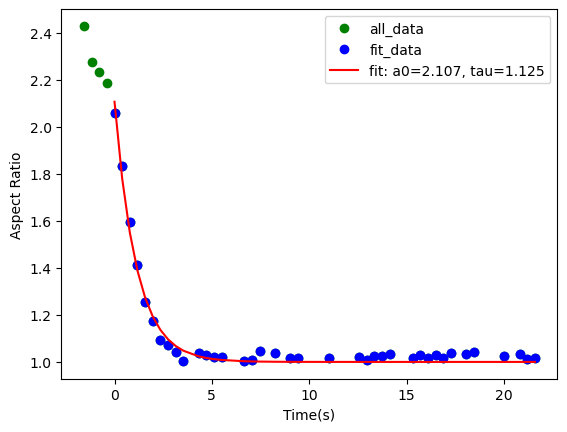

PolyPFusion_tifFiles/20240608_57_L_P700-1mgml_MgCl2-100mM_NoDNA-0ngul_YOYO1-0uM_P700AF647-10per_488-0-0-0-0_633-3-800-600-1_pixelDwell-1.27-390.98ms_timeseries-0ms_12.5min_141-190.tif


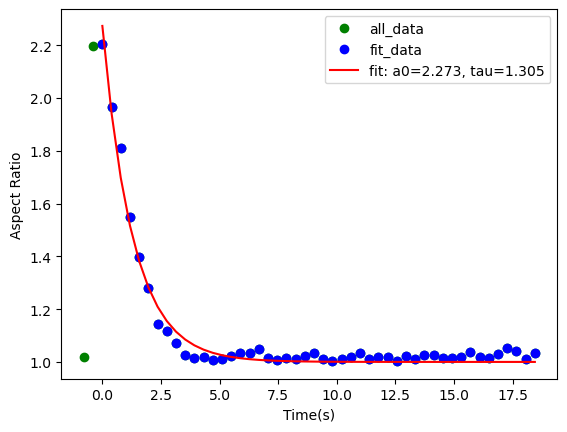

In [6]:
# Place for storing outputs/data
attributes_dict = {}
a0_list = []
tau_list = []
major_axis = []
parse_key_list = []
n_fit_list = []
index_zero_list = []

# setting parameters for analysis: see previous section for reasoning on selection
analysis_var = 'clean'
fit_function = "two_param_fit"
properties = ['area', 'axis_major_length', 'axis_minor_length']

# Analyzes each file individually and appends to lists/dicts
for file in file_list:
    
    im = skimage.io.imread(file) 
    
    #time_int is a parameter set by experimental conditions--it is the time between frames for our images collected on Zeiss LSM780
    obj =  ar.DropletFusion(im,properties,time_int = 0.39251)
    
    if obj.valid_properties:
        #If RuntimeError: Parsekey does not have the same numbers of entries as the file path, change "/" to "\" or "\\"
        file_name = file.split('/')[-1][:-4] 

        #Only needed if exporting image:
        parameters = file_name.split("_")
        file_identifier = "{date}_{imageno}_{sample}_{readingframes}".format(
            date = parameters[0], 
            imageno = parameters[1],
            sample = parameters[2], 
            readingframes = parameters[-1])

        #Processing & Fitting 
        print(file)
        obj.clean_image()
        obj.calc_properties(analysis_var)          
        obj.calc_aspect_ratio()
        obj.fit_relaxation(fit_function)
        obj.graph_fit(fit_function, 
                      save_graph = False, 
                      file_name = file_identifier, 
                      file_type = "svg")

    #     #Uncomment lines below for export of figures
    #     obj.segmentation_overlay(analysis_var, surpress_show = True)
    #     obj.image_fig(analysis_var,surpress_show = True)
    #     obj.export_figs('all',file_name = file_identifier, file_type = "png")

        #Saves region and aspect ratio related parameters
        attributes_dict[file] = obj.aspect_ratio

        #Takes title names and translates into a dictionary of experimental parameters for identification/indexing
        pk_init = pw.ParseName(file_name,fusion_240611)
        pk_init.parse_name()
        parse_key_list.append(pk_init.return_parsekey_dict())

        #Saves fitting parameters
        a0_list.append(obj.aspect_ratio['popt'][0])
        tau_list.append(obj.aspect_ratio['popt'][1])
        major_axis.append(obj.aspect_ratio['majorAxis0'])
        n_fit_list.append(obj.aspect_ratio['n_fit'])
        index_zero_list.append(obj.aspect_ratio['index_zero'])

#### Combining data 

Takes the parameters and values from the titles and combines into a dict with format category: [values]. Each value in values is a separate file.

In [7]:
combined_pk = {}
for key in parse_key_list[0].keys():
    combined_pk[key] = list(d[key] for d in parse_key_list)

Combines data into a single dataframe

In [8]:
dataframe = pd.DataFrame(combined_pk)

# Adds columns for fitting parameters
dataframe['a0'] = a0_list
dataframe['tau'] = tau_list
dataframe['MajorAxis'] = major_axis
dataframe['n_fit'] = n_fit_list
dataframe['index_zero'] = index_zero_list

# Converts units & length: 
## Major Axis -> microns from pixels
## Calculates tau/l for reference
dataframe['majorAxis (um)'] = dataframe['MajorAxis']/2/6.0222
dataframe['tau/l (s/um)'] = dataframe['tau']/dataframe['majorAxis (um)']
dataframe

Date ReadingNo Sample PolyP  [PolyP] (mg/mL) Component 2  \
0    20240608        91      S  P700              1.0       MgCl2   
1    20240608        66      N  P700              1.0       MgCl2   
2    20240608        65      N  P700              1.0       MgCl2   
3    20240608        21      E  P700              1.0       MgCl2   
4    20240608        36      H  P700              1.0       MgCl2   
..        ...       ...    ...   ...              ...         ...   
118  20240608        22      E  P700              1.0       MgCl2   
119  20240608        72      O  P700              1.0       MgCl2   
120  20240608        92      S  P700              1.0       MgCl2   
121  20240608        86      R  P700              1.0       MgCl2   
122  20240608        57      L  P700              1.0       MgCl2   

     [Component 2] (mM)    DNA  [DNA] (ng/uL) DNALabel  ...  Delay (ms)  \
0                 100.0   15kb           10.0    YOYO1  ...         0.0   
1                 100.0  pUC19           10.0    YOYO1  ...         0.0   
2                 100.0  pUC19           10.0    YOYO1  ...         0.0   
3                 100.0  pUC19           10.0    YOYO1  ...         0.0   
4                 100.0   15kb           10.0    YOYO1  ...         0.0   
..                  ...    ...            ...      ...  ...         ...   
118               100.0  pUC19           10.0    YOYO1  ...         0.0   
119               100.0   15kb           10.0    YOYO1  ...         0.0   
120               100.0   15kb           10.0    YOYO1  ...         0.0   
121               100.0  pUC19           10.0    YOYO1  ...         0.0   
122               100.0  NoDNA            0.0    YOYO1  ...         0.0   

    Time (min)  ReadingFrames        a0       tau  MajorAxis  n_fit  \
0         10.0          30-85  2.189793  0.809714   26.78223     49   
1         10.0        276-310  2.042671  1.964679  61.257656     27   
2          7.5          47-96  2.293324  1.313846  41.795048     46   
3          7.5        170-219  2.258255  1.343753  40.299748     49   
4         10.0        113-159  2.231402  0.921522  25.561321     40   
..         ...            ...       ...       ...        ...    ...   
118       10.0        249-298  2.431084  1.382661   37.59101     50   
119       12.5        138-187  2.247874  0.676409  24.889668     49   
120       12.5        155-204  2.111528  0.835865  31.730501     31   
121       10.0        196-255  2.107048  1.124792  35.294435     38   
122       12.5        141-190  2.273254  1.304816  41.586288     48   

     index_zero majorAxis (um)  tau/l (s/um)  
0           7.0       2.223625      0.364142  
1           8.0       5.085987      0.386293  
2           4.0       3.470081      0.378621  
3           1.0       3.345932      0.401608  
4           5.0       2.122258      0.434218  
..          ...            ...           ...  
118         0.0       3.121036      0.443014  
119         1.0       2.066493      0.327322  
120        15.0       2.634461      0.317281  
121         4.0       2.930361      0.383841  
122         2.0       3.452749      0.377906  

[123 rows x 37 columns]

#### Export to csv

In [9]:
dataframe.to_csv("2024_ChawlaTomEtAl_PolyPFusion_combined.csv")